# Streamflow analysis functions

In [2]:
# Import packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

import dataretrieval.nwis as nwis # for downloading observed streamflow data from USGS
from matplotlib.dates import MonthLocator, DateFormatter # for plotting month on x-axis

In [3]:
# Conversions
MAF_to_km3 = 1e6 * 43560 * 0.0283 * 1e-9
km3_to_MAF = 1 / (1e6 * 43560 * 0.0283 * 1e-9)
cfs_to_maf = 60 * 60 * 24 / 43560 / 1e6
cfs_to_km3 = 60 * 60 * 24 * 0.0283 * 1e-9

### Functions for downloading streamflow data (observed, unimpaired, 40% unimpaired with ferc)

In [4]:
# Define variables
sites = [11289650, 11290000] # Tuolumne R Bl Lagrange Dam Nr Lagrange CA, Tuolumne R at Modesto

#start_year = '1929'
start_year = '1993'
start_date = start_year+'-10-01' # '1929-10-01'
#end_date = '2015-04-28' # ending date for Kocis paper
end_year = '2023'
end_date = end_year+'-09-30' # include most recent 30-year record

percentile = 90

selected_threshold = 'p90'

In [4]:
# Observed flows: Download observed daily streamflow (USGS)
def download_obs_flow(site_id, start_date, end_date):
    df = nwis.get_record(sites=str(site_id), service='dv', start=start_date, end=end_date, parameterCd='00060').drop(columns=['00060_Mean_cd', 'site_no']).rename(columns={'00060_Mean': 'flow_cfs'})
    return df

# Unimpaired flows: Replace negative values with linear interpolation (for UF dataset)
def replace_nan_with_avg(series):
    for i in range(len(series)):
        if pd.isna(series[i]):
            before = series[i - 1] if i > 0 and not pd.isna(series[i - 1]) else 0
            after = series[i + 1] if i < len(series) - 1 and not pd.isna(series[i + 1]) else 0
            series[i] = (before + after) / 2
    return series

# Unimpaired flows: Download and clean unimpaired flow (UF) daily streamflow
def download_uf(link_raw, link_clean):
    df = pd.read_csv(link_raw, index_col=0)
    df = df.mask(df < 0, np.nan) # replace negative values with NaN
    df = df.apply(replace_nan_with_avg) # replace NaN values with average
    df.rename(columns={'TLG_FNF_CFS':'flow_cfs'}, inplace=True)
    df.to_csv(link_clean)
    #df.to_csv('C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows\\data_analysis\\data_clean\\fnf_tuol_cdec_CLEAN.csv')
    return df

# # Function to get streamflow data ('daily') for selected flow type
# def download_streamflow_data(flow_type):
#     if flow_type == 'obs':
#         if site_id == 11447650: # Sacramento River at Freeport daily data stored in two locations by USGS
#             #daily = grab_usgs_mean_daily_streamflow(site_id, start_date, end_date)
#             discharge_daily = nwis.get_record(sites=str(site_id), service='dv', start=start_date, end = end_date, parameterCd='00060').drop(columns=['00060_Mean_cd', 'site_no']).rename(columns={'00060_Mean': 'flow_cfs'})
#             #discharge_daily2 = nwis.get_record(sites=str(site_id), service='dv', start='2015-10-01', end=end_date, parameterCd='72137').drop(columns=['72137_Mean_cd', 'site_no']).rename(columns={'72137_Mean': 'flow_cfs'})
#             #discharge_daily = pd.concat([daily1, daily2])
#         else: # all other gauges store daily data in parameterCd 00060
#             discharge_daily = download_obs_flow(site_id, start_date, end_date)
#     elif flow_type == 'uf':
#         discharge_daily = clean_uf_data('C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows\\data_analysis\\data_raw\\fnf_tuol_cdec.csv')
#     else:
#         discharge_daily = pd.read_csv('C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows\\data_analysis\\data_clean\\fnf_with_ferc.csv', index_col=0, parse_dates=True)
#     #fnf = cdec_sensor_data(cdec_sensor, 8, 'D', sd='1993-10-01', ed='2022-09-30')
#     return discharge_daily

### Functions for determining thresholds to calculate HMF

In [5]:
# Threshold functions to calculate HMF ###

# Calculate specified percentile streamflow over given streamflow record
def calc_threshold(df, percentile):
    return round(df['flow_cfs'].quantile(percentile), 1)

# Calculate flows associated with selected return periods
def calc_retper_flow(site_id, T):
#     if sites_df.loc[site_id, 'peakData'] == 'y':
#         qpeakDF = nwis.get_record(sites=str(site_id), service='peaks', start=start_date, end=end_date).drop(columns=['agency_cd', 'site_no'])
#         qpeak = qpeakDF['peak_va']
#     else:
#         daily = nwis.get_record(sites=str(site_id), service='dv', start=start_date, end=end_date, parameterCd='00060').drop(columns=['00060_Mean_cd', 'site_no']).rename(columns={'00060_Mean': 'flow_cfs'})
#         qpeak = daily['flow_cfs'].resample('AS-OCT').max()
#         print(qpeak)
    qpeakDF = nwis.get_record(sites=str(site_id), service='peaks', start=start_date, end=end_date).drop(columns=['agency_cd', 'site_no'])
    qpeak = qpeakDF['peak_va']
    x = qpeak.values
    x[x == 0] = 0.01    
    y = np.log(x)
    m = np.mean(y) # sample mean in LOG SPACE
    s = np.std(y) # sample STD in LOG SPACE
    Zp = stats.norm.ppf(1 - 1/T) # Z-score for 99%; inverse CDF 
    g = stats.skew(y)
    Kp = (2/g)*(1 + g*Zp/6 - g**2/36)**3 - 2/g
    return np.exp(m + Kp*s)

def calc_thresholds_flow(df, site_id):
    # Set up df with column names
    key_names = ['p90', '2yr_event', '3yr_event', '5yr_event', '10yr_event', 'flood_DWR']
    
    # Calculate thresholds
    p90 = calc_threshold(df, 0.9)
    ret_per = [2, 3, 5, 10]
    for T in ret_per:
        flow = calc_retper_flow(site_id, T)
        if T == 2:
            retper_2yr = flow 
        elif T == 3:
            retper_3yr = flow 
        elif T == 5:
            retper_5yr = flow 
        else:
            retper_10yr = flow 
    flood_DWR = 8500 # cfs, Tuolumne R. only
            
    # Create list of threshold values
    values_list = [p90, retper_2yr, retper_3yr, retper_5yr, retper_10yr, flood_DWR]
    
    # Create dictionary of threshold labels as keys and flows as values
    dictionary = dict(zip(key_names, values_list))
    
    #thresholds_obs.to_csv(file_name)
    return dictionary

def calc_thresholds_percentiles(df, thresholds_flow_df):
    key_names = ['p90', '2yr_event', '3yr_event', '5yr_event', '10yr_event', 'flood_DWR']
    
    # Calculate thresholds and create list
    pctl_list = []
    for threshold in key_names:
        pctl = round((df['flow_cfs'] < thresholds_flow_df[threshold]).mean(), 2)
        pctl_list.append(pctl)

    # Create dictionary of threshold labels as keys and flows as values
    dictionary = dict(zip(key_names, pctl_list))
    
    return dictionary

# Create column with WY 
def add_WY_DOHY_month(df):
    df['datetime'] = pd.to_datetime(df.index)
    df['month'] = df['datetime'].dt.strftime('%m') # create month column
    df['year'] = df['datetime'].dt.strftime('%Y') # create year column 
    df['WY'] = np.where((df['month'] == '10') | (df['month'] == '11') | (df['month'] == '12'), df['year'].astype(int) + 1, df['year'].astype(int)) # create WY column where the WY resets in Oct
    df['WY'] = df['WY'].values.astype(str)
    df['DOY'] = df['datetime'].dt.dayofyear # create column with DOY
    df['DOHY'] = [d - 273 if d >= 274 else d + 91 for d in df['DOY']]
    df['datetime'] = df['datetime'].dt.date # reset index to date only (no time)
    df.set_index('datetime', inplace=True)
    columns_to_remove = ['year']
    df = df.drop(columns=columns_to_remove)
    return df
    
def calc_HMF(thresholds_flowDict, site_id, selected_threshold, df): # HMF = discharge above threshold
    threshold = float(thresholds_flowDict[site_id][selected_threshold])
    FlowAbvThresholdList = [(flow - threshold) if flow > threshold else 0 for flow in df['flow_cfs']]
    df['HMF_cfs'] = FlowAbvThresholdList
    return df

# Save observed USGS data for Tuolumne R at LGR
observed_tuol_usgs = download_obs_flow('11289650', start_date, end_date)
observed_tuol_usgs.to_csv('C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows_ca\\data_analysis\\data_clean\\observed_tuol_usgs.csv')

### Functions for adding daily streamflows (obs, uf, 40% uf ferc) to a dictionary

In [8]:
# Define dictionaries to save daily discharge and threshold dataframes
flowDict = {}
thresholds_flowDict = {}
thresholds_percentileDict = {}

# Observed flows at multiple sites
for site_id in sites:
    discharge_daily = download_obs_flow(site_id, start_date, end_date)
#     if site_id == 11447650: # Sacramento River at Freeport daily data stored in two locations by USGS
#         #daily = download_obs_flow(site_id, start_date, end_date)
#         discharge_daily = nwis.get_record(sites=str(site_id), service='dv', start=start_date, end = end_date, parameterCd='00060').drop(columns=['00060_Mean_cd', 'site_no']).rename(columns={'00060_Mean': 'flow_cfs'})
#         #discharge_daily2 = nwis.get_record(sites=str(site_id), service='dv', start='2015-10-01', end=end_date, parameterCd='72137').drop(columns=['72137_Mean_cd', 'site_no']).rename(columns={'72137_Mean': 'flow_cfs'})
#         #discharge_daily = pd.concat([daily1, daily2])
#     else: # all other gauges store daily data in parameterCd 00060
#         discharge_daily = download_obs_flow(site_id, start_date, end_date)
    thresholds_flowDict[site_id] = calc_thresholds_flow(discharge_daily, site_id)
    thresholds_percentileDict[site_id] = calc_thresholds_percentiles(discharge_daily, thresholds_flowDict[site_id])
    discharge_daily = add_WY_DOHY_month(discharge_daily)
    discharge_daily = calc_HMF(thresholds_flowDict, site_id, selected_threshold, discharge_daily)
    flowDict['obs_'+str(site_id)] = discharge_daily 
    
# Unimpaired flows at TLG
uf_11289650 = download_uf('C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows_ca\\data_analysis\\data_raw\\fnf_tuol_cdec.csv',
                         'C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows_ca\\data_analysis\\data_clean\\fnf_tuol_cdec_CLEAN.csv')
#fnf_11289650 = pd.read_csv('C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows\\data_analysis\\data_clean\\fnf_tuol_cdec_CLEAN.csv', index_col=0, parse_dates=True)
uf_11289650 = add_WY_DOHY_month(uf_11289650)
flowDict['uf_11289650'] = uf_11289650

# 40% Unimpaired flows with FERC at TLG
#fnf_ferc_11289650 = pd.read_csv('C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows\\data_analysis\\data_clean\\fnf_with_ferc.csv', index_col=0, parse_dates=True)
%run unimp_ferc_flow_construction.ipynb
uf_ferc_11289650 = add_WY_DOHY_month(uf_ferc_11289650)
flowDict['uf_ferc_11289650'] = uf_ferc_11289650
#fnf_ferc_11289650 = calc_HMF(thresholds_flowDict, site_id, selected_threshold, fnf_ferc_11289650

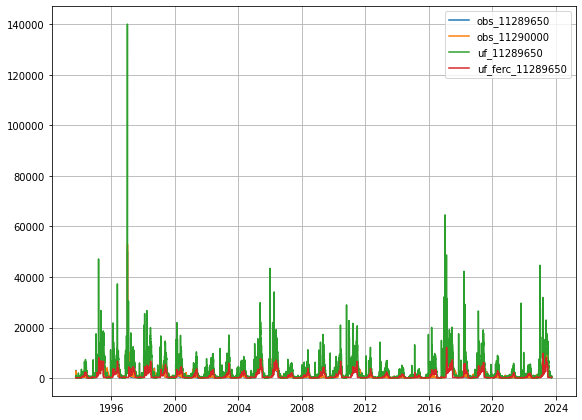

In [9]:
# Plot flow types in flowDict

flow_types = list(flowDict.keys())
plt.rcParams['axes.grid'] = True
fig, ax = plt.subplots(1,1, figsize=(8,6))
fig.tight_layout()

for flow_type in flow_types:
    ax.plot(flowDict[flow_type]['flow_cfs'], label=flow_type)
plt.legend()
plt.show()

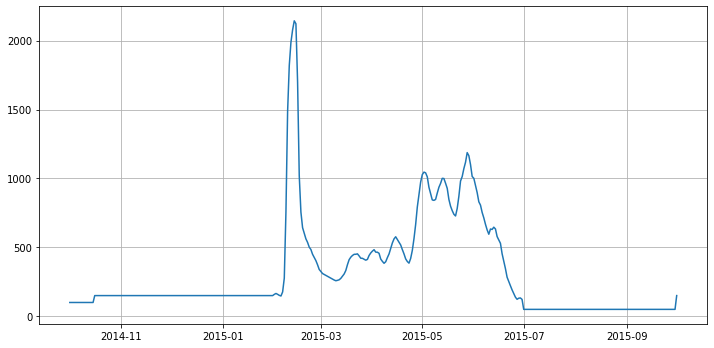

In [10]:
def plot_single_year(df, year):
    df = df.reset_index()
    df['datetime']= pd.to_datetime(df['datetime'])
    PLOT_START = str(year)+'-10-01'
    next_year = year+1
    PLOT_END = str(next_year)+'-10-01'
    df_plot = df.loc[(df['datetime'] >= PLOT_START) & (df['datetime'] <= PLOT_END)]
    #ax.plot(df_plot['flow_cfs'], label=flow_type)
    return df_plot

year = 2014
plt.rcParams['axes.grid'] = True
fig, ax = plt.subplots(1,1, figsize=(10,5))
fig.tight_layout()
df_plot = plot_single_year(flowDict['uf_ferc_11289650'], year)
ax.plot(df_plot['datetime'], df_plot['flow_cfs'], label=flow_type)
plt.show()

### Upload CEFF flows at TLG

In [11]:
data_raw = 'C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows_ca\\data_analysis\\data_clean\\flow_2823750_mean_estimated_1950_2023_monthly.csv'
start_date_uf = uf_ferc_11289650.index.min()
end_date_uf = uf_ferc_11289650.index.max()

def ceff_mean_monthly(data_raw):
    # Open csv as df
    df = pd.read_csv(data_raw, index_col=0, parse_dates=True)
    
    # Create a date column from the year and month columns
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
    
    # Set the index as the date column
    df.set_index('date', inplace=True)
    
    # Rename the value column as flow and remove dfs
    df.rename(columns={'value': 'flow_cfs'}, inplace=True)
    df = df.drop(['statistic', 'variable', 'year', 'month'], axis=1)
    
    # Add WY to df
    df = add_WY_DOHY_month(df)
    
    # Select rows to match other dfs
    df = df[start_date_uf:end_date_uf]
    
    return df

ceff_mean_11289650 = ceff_mean_monthly(data_raw)

### Upload water rights data

## Functions for calculating flow metrics for individual sites

In [5]:
# Import packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import dataretrieval.nwis as nwis # for downloading observed streamflow data from USGS
from scipy import stats # to calculate return period flows
from datetime import timedelta # to calculate difference between two dates

In [397]:
# USGS gage number
site_no = 11289650 # Tuolumne R Bl Lagrange Dam Nr Lagrange CA
#site_no = 11290000 # Tuolumne R at Modesto CA
#site_no = '11447650' # Sacramento R at Freeport CA
#site_no = '11303500' # San Joaquin R at Vernalis

# Specify date range for streamflow record
#start_date = '1948-10-01' # starting date for Kocis paper
start_year = '1999'
start_date = start_year+'-10-01' # '1929-10-01'
#end_date = '2014-09-30' # ending date for Kocis paper
end_year = '2023'
end_date = end_year+'-09-30'

# Calculation constants
selected_threshold = 'p90'
percentile = 0.90

In [487]:
## FUNCTIONS

###################################
#### USGS DATA AND DF CLEANING ####
# Observed flows: Download observed daily streamflow (USGS)
def download_usgs_data(site_no, start_date, end_date):
    df = nwis.get_record(sites=str(site_no), service='dv', start=start_date, end=end_date, parameterCd='00060').drop(columns=['00060_Mean_cd', 'site_no']).rename(columns={'00060_Mean': 'flow_cfs'})
    return df

# Add columns with month, day, year, WY, DOY, DOHY 
def add_datetime_data(df):
    df['datetime'] = pd.to_datetime(df.index)
    df['day'] = df['datetime'].dt.strftime('%d')
    df['month'] = df['datetime'].dt.strftime('%m')
    df['year'] = df['datetime'].dt.strftime('%Y')
    df['WY'] = np.where((df['month'] == '10') | (df['month'] == '11') | (df['month'] == '12'), df['year'].astype(int) + 1, df['year'].astype(int)) # create WY column where the WY resets in Oct
    df['WY'] = df['WY'].values.astype(str)
    df['DOY'] = df['datetime'].dt.dayofyear
    df['DOHY'] = [d - 273 if d >= 274 else d + 92 for d in df['DOY']] # in leap years, need to change to d + 93
    df['datetime'] = df['datetime'].dt.date # reset index to date only (no time)
    df.set_index('datetime', inplace=True)
    df.index = pd.to_datetime(df.index)
    #columns_to_remove = ['year']
    #df = df.drop(columns=columns_to_remove)
    return df

###########################
#### RECORD PERCENTILE ####
# Calculate specified percentile streamflow over given streamflow record
def calc_record_threshold(df, percentile):
    return round(df['flow_cfs'].quantile(percentile), 1)

# Create a df with of the hmf flows for all days of the streamflow record
def calc_record_hmf(df, threshold):
    df['hmf_cfs'] = [(flow - threshold) if flow > threshold else 0 for flow in df['flow_cfs']]
    return df

# Calculate hmf capped at 20% of daily streamflow
def calc_record_hmf_capped(df, threshold):
    df['20pct'] = [flow * 0.2 for flow in df['flow_cfs']]
    df['hmf_cfs_no_cap'] = [(flow - threshold) if flow > threshold else 0 for flow in df['flow_cfs']]
    df['hmf_cfs'] = df[['20pct', 'hmf_cfs_no_cap']].min(axis=1)
    return df

##########################
#### DAILY PERCENTILE ####
# Calculate specified percentile streamflow for individual days of the year
def calc_daily_threshold(df, percentile):
    days_of_year_list = df['DOY'].unique().tolist()
    daily_threshold_dict = {}
    
    for day in days_of_year_list:
        mask_df = df[df['DOY'].isin([day])]
        mask_threshold = calc_record_threshold(mask_df, percentile)
        daily_threshold_dict[day] = mask_threshold
        daily_threshold_dict_sorted = dict(sorted(daily_threshold_dict.items()))
        
    df['threshold_cfs'] = df['DOY'].map(daily_threshold_dict_sorted)
    return daily_threshold_dict_sorted, df

# Create a df with of the hmf flows for individual days of the streamflow record
def calc_daily_hmf(df):
    df['hmf_cfs'] = df['flow_cfs'] - df['threshold_cfs']
    df['hmf_cfs'] = df['hmf_cfs'].clip(lower=0)
    #df = df.drop(columns=['flow_cfs'])
    #df = df.rename(columns={'hmf_cfs':'flow_cfs'})
    return df

# Calculate hmf capped at 20% of daily streamflow
def calc_daily_hmf_capped(df):
    df['20pct'] = [flow * 0.2 for flow in df['flow_cfs']]
    df['hmf_cfs_no_cap'] = df['flow_cfs'] - df['threshold_cfs']
    df['hmf_cfs_no_cap'] = df['hmf_cfs_no_cap'].clip(lower=0)
    df['hmf_cfs'] = df[['20pct', 'hmf_cfs_no_cap']].min(axis=1)
    return df

########################
#### RETURN PERIODS ####
def calc_retper_flow(site_no, T):
    qpeakDF = nwis.get_record(sites=str(site_no), service='peaks', start=start_date, end=end_date).drop(columns=['agency_cd', 'site_no'])
    qpeak = qpeakDF['peak_va']
    x = qpeak.values
    x[x == 0] = 0.01    
    y = np.log(x)
    m = np.mean(y) # sample mean in LOG SPACE
    s = np.std(y) # sample STD in LOG SPACE
    Zp = stats.norm.ppf(1 - 1/T) # Z-score for 99%; inverse CDF 
    g = stats.skew(y)
    Kp = (2/g)*(1 + g*Zp/6 - g**2/36)**3 - 2/g
    return np.exp(m + Kp*s)

def calc_thresholds_flow(site_no, start_date, end_date, percentile):
    # Set up df with column names
    key_names = ['p90', 'median_wet_seas_flow_10', 'median_wet_seas_flow_50', 'median_wet_seas_flow_90', '2yr_event', '3yr_event', '5yr_event', '10yr_event', 'flood_DWR', 'peak_2yr_10']
    
    # Calculate thresholds
    df = download_usgs_data(site_no, start_date, end_date)
    df = add_datetime_data(df)
    p90 = calc_record_threshold(df, percentile)
    median_wet_seas_flow_10 = 1810 # cfs, Tuolumne R. only
    median_wet_seas_flow_50 = 3130 # cfs, Tuolumne R. only
    median_wet_seas_flow_90 = 5110 # cfs, Tuolumne R. only
    
    ret_per = [2, 3, 5, 10]
    for T in ret_per:
        flow = calc_retper_flow(site_no, T)
        if T == 2:
            retper_2yr = flow 
        elif T == 3:
            retper_3yr = flow 
        elif T == 5:
            retper_5yr = flow 
        else:
            retper_10yr = flow 
    flood_DWR = 8500 # cfs, Tuolumne R. only
    peak_2yr_10 = 9380 # cfs, Tuolumne R. only
            
    # Create list of threshold values
    values_list = [p90, median_wet_seas_flow_10, median_wet_seas_flow_50, median_wet_seas_flow_90, retper_2yr, retper_3yr, retper_5yr, retper_10yr, flood_DWR, peak_2yr_10]
    
    # Create dictionary of threshold labels as keys and flows as values
    dictionary = dict(zip(key_names, values_list))
    
    #thresholds_obs.to_csv(file_name)
    return dictionary

#########################
######## METRICS ########
# Calculate annual magnitude (total magntiude above threshold)
def calc_mag_maf(df):
    #df.set_index('datetime', inplace=True)
    annual_vol_abv_threshold = df['hmf_cfs'].resample('AS-OCT').sum() * cfs_to_maf # MAF, total flow above threshold for all years (including non-HMF years)
    return annual_vol_abv_threshold # returns series

def calc_annual_dur(df):
    df = df.reset_index()
    df['datetime'] = df['datetime'] + pd.DateOffset(months=-9)
    df['flow_bool'] = df['hmf_cfs'].apply(lambda x: 1 if x > 0 else 0)
    df_results = df.groupby(df["datetime"].dt.year)['flow_cfs'].sum()
    df_results["total_days"] = df.groupby(df['datetime'].dt.year)["flow_bool"].sum()
    return df_results['total_days']

def calc_event_mag_event_dur_intra_annual_fre(df):
    df = df.reset_index()
    df['datetime'] = df['datetime'] + pd.DateOffset(months=-9)
    df['flow_bool'] = df['hmf_cfs'].apply(lambda x: 1 if x > 0 else 0)
    df_results = df.groupby(df["datetime"].dt.year)['flow_cfs'].sum().reset_index()
    df_results["total_days"] = df.groupby(df['datetime'].dt.year)["flow_bool"].sum().reset_index()["flow_bool"]
    
    # Total events per year calculation
    # Insert a day at the very beginning of the dataframe with flow_bool == 0 so that the first event is counted via diff()
    first = df['datetime'].iloc[0] - timedelta(days=1)
    insert = {'datetime': first, 'flow_cfs': 0,  'day': None, 'month': None, 'year': None, 'WY': None, 'DOY': None, 'DOHY': None, 'threshold_cfs': None, 'hmf_cfs': None, 'flow_bool': 0}
    df = pd.concat([pd.DataFrame(insert, index=[0]), df]).reset_index(drop=True)
    df['year'] = df['datetime'].dt.year
    df['change'] = df['flow_bool'].diff()
    df['year_change'] = df['year'].diff()

    # Edgecase where flow carries over from previous year
    df.loc[((df['year_change'] > 0) & (df['flow_bool'] == 1)), 'change'] = 1

    '''# Set Change == 1 if the first day of the year has an event to account for events spanning the new year
    year_start_mask = (df_d['datetime'].dt.month == 1) & (df_d['datetime'].dt.day == 1)
    df_d.loc[year_start_mask & (df_d['flow_bool'] == 1), 'Change'] = 1'''

    series_continuous_sets = df[(df['change'] == 1) & (df['flow_bool'] == 1)].groupby('year').size()
    series_continuous_sets = series_continuous_sets.reset_index()
    series_continuous_sets.columns = ['year', 'total_events']
    
    df_results.rename(columns={'datetime': 'year'}, inplace=True)
    df_results = pd.merge(df_results, series_continuous_sets, on='year', how='left')
    df_results = df_results.fillna(0)
    df_results.set_index('year', inplace=True)
    
    df_results['event_mag'] = df_results['flow_cfs'] / df_results['total_events'] * cfs_to_maf
    df_results['event_mag'] = df_results['event_mag'].replace([np.nan, np.inf, -np.inf], 0)
    
    df_results['event_dur'] = df_results['total_days'] / df_results['total_events']
    df_results['event_dur'] = df_results['event_dur'].replace([np.nan], 0)
    
    return df_results['event_mag'], df_results['event_dur'], df_results['total_events']

# # Calculate annual duration (annual number of days above threshold)
# def sum_values_above_one(series):
#     return sum(1 for flow in series if flow > 0)

# def calc_dur_days(df):
#     #df.set_index('datetime', inplace=True)
#     days_abv_threshold = df['hmf_cfs'].resample('AS-OCT').apply(sum_values_above_one)
#     return days_abv_threshold # return series

# # Calculate event duration
# def list_of_consec_days_per_event(series): # x is HMF series
#     event_duration = 0
#     event_duration_list = []
    
#     # create list that records 0 for 0 HMF days and records number of consecutive HMF days
#     for flow in series:
#         event_duration += 1
#         if flow == 0:
#             event_duration = 0
#         event_duration_list.append(event_duration)
#     # create new list of the maximum duration of each event (only records a number that is greater than the previous day 
#     # and greater than the next day, since the next day should = 0)
#     max_event_duration_list = [event_duration_list[i] for i in range(len(event_duration_list)-1) 
#                              if (event_duration_list[i - 1] < event_duration_list[i]) and (event_duration_list[i] > event_duration_list[i + 1])]
#     return max_event_duration_list

# def mean_days_per_event(series):
#     max_event_duration_list = list_of_consec_days_per_event(series)
#     return np.mean(max_event_duration_list) # take average value in each list

# def calc_event_dur_days(df):
#     #df.set_index('datetime', inplace=True)
#     avg_event_duration = df['hmf_cfs'].resample('AS-OCT').apply(mean_days_per_event)
#     avg_event_duration = avg_event_duration.fillna(0)
#     return avg_event_duration

# # Calculate event frequency 
# def mean_number_of_events(x):
#     max_event_duration_list = list_of_consec_days_per_event(x)
#     return len(max_event_duration_list) # use this for average number of events over some time span

# def calc_event_fre(df):
#     #df.set_index('datetime', inplace=True)
#     avg_number_of_events = df['hmf_cfs'].resample('AS-OCT').apply(mean_number_of_events)
#     return avg_number_of_events

# Calculate inter-annual frequency
def calc_inter_ann_fre(df):  
    #df.set_index('datetime', inplace=True)
    hmf_years = df.loc[df['hmf_cfs'] != 0].WY.unique() # list of WYs with HMFs
    all_years = df.WY.unique() # list of all WYs
    hmf_years_list = [1 if year in hmf_years.tolist() else 0 for year in all_years] # list of 0 or 1 for WY without and with HMF
    inter_ann_fre = round(len(hmf_years) / len(all_years) * 100, 1)
    return inter_ann_fre # returns value

# Calculate timing
def center_of_mass(x):
    num = 0
    den = 0
    for i in range(len(x)):
        num += x[i] * i
        den += x[i]
    return (num/den)

def calc_tim(df):
    #df.set_index('datetime', inplace=True)
    com_list = df['hmf_cfs'].resample('AS-OCT').apply(center_of_mass)
    com_list = com_list.fillna(0)
    return com_list # returns series


# Calculate zero-deflated mean for given series
def calc_zero_deflated_mean(annual_timeseries):
    avg_metric = annual_timeseries[annual_timeseries != 0].dropna().mean()
    return avg_metric

def create_summary_table(df):
    # Create summary table to store data for each flow characteristic
    cols = ['mag_maf',
            'annual_dur', 
            #'inter_ann_fre', 
            #'tim_dohy',
            'event_mag',
            'event_dur',
            'intra_annual_fre',
            'timing'
            ]
    
    rows = ['count','mean','std','min','25%','50%','75%','max']
    
    summary = pd.DataFrame(columns=cols, index=rows)
    
    data = pd.DataFrame({'mag_maf': calc_mag_maf(df).tolist(),
                        'annual_dur': calc_annual_dur(df),
                        #'inter_ann_fre': calc_inter_ann_fre(df), 
                        'event_mag': calc_event_mag_event_dur_intra_annual_fre(df)[0], 
                        'event_dur': calc_event_mag_event_dur_intra_annual_fre(df)[1], 
                        'intra_annual_fre': calc_event_mag_event_dur_intra_annual_fre(df)[2],
                        'timing': calc_tim(df).tolist()
                        })
    for j in cols:
            #print(j)
            summary.loc['count',j] = data[data[j] != 0][j].size
            summary.loc['mean',j] = np.mean(data[data[j] != 0][j])
            summary.loc['std',j] = np.std(data[data[j] != 0][j])
            summary.loc['min',j] = np.amin(data[data[j] != 0][j])
            summary.loc['25%',j] = np.quantile(data[data[j] != 0][j], 0.25)
            summary.loc['50%',j] = np.quantile(data[data[j] != 0][j], 0.5)
            summary.loc['75%',j] = np.quantile(data[data[j] != 0][j], 0.75)
            summary.loc['max',j] = np.amax(data[data[j] != 0][j])
            
    return data, summary

### HMF metrics using DAILY thresholds (not capped and capped at 20% daily flow)

In [488]:
# HMF using daily thresholds - not capped at 20% daily flow
df = download_usgs_data(site_no, start_date, end_date)
df = add_datetime_data(df)
daily_threshold_dict_sorted, df_daily_threshold_no_hmf = calc_daily_threshold(df, percentile)
df_daily_threshold = calc_daily_hmf(df_daily_threshold_no_hmf)

# HMF using daily thresholds - capped at 20% daily flow
df_daily_threshold_capped = calc_daily_hmf_capped(df_daily_threshold_no_hmf.copy())

# Annual magnitude
annual_mag_series_daily_thres = calc_mag_maf(df_daily_threshold)
annual_avg_mag_daily_thres = calc_zero_deflated_mean(annual_mag_series_daily_thres)
print(f'Annual Average Magnitude Above Daily Threshold: {annual_avg_mag_daily_thres: 0.2f} MAF/year')

annual_mag_series_daily_thres = calc_mag_maf(df_daily_threshold_capped)
annual_avg_mag_daily_thres = calc_zero_deflated_mean(annual_mag_series_daily_thres)
print(f'Annual Average Magnitude Above Daily Threshold (Capped at 20% Daily Flow): {annual_avg_mag_daily_thres: 0.2f} MAF/year')

# Annual duration
annual_dur_series_daily_thres = calc_annual_dur(df_daily_threshold)
annual_avg_dur_daily_thres = calc_zero_deflated_mean(annual_dur_series_daily_thres)
print(f'Annual Average Duration Above Daily Threshold: {annual_avg_dur_daily_thres: 0.2f} days/year')

# Event magnitude
event_mag_series_daily_thres = calc_event_mag_event_dur_intra_annual_fre(df_daily_threshold)[0]
avg_event_mag_daily_thres = calc_zero_deflated_mean(event_mag_series_daily_thres)
print(f'Annual Average Event Magnitude Above Daily Threshold: {avg_event_mag_daily_thres: 0.1f} MAF/year')

# Event duration
event_dur_series_daily_thres = calc_event_mag_event_dur_intra_annual_fre(df_daily_threshold)[1]
avg_event_dur_daily_thres = calc_zero_deflated_mean(event_dur_series_daily_thres)
print(f'Annual Average Event Duration Above Daily Threshold: {avg_event_dur_daily_thres: 0.1f} days/event')

# Event frequency
intra_ann_fre_series_daily_thres = calc_event_mag_event_dur_intra_annual_fre(df_daily_threshold)[2]
avg_intra_ann_fre_series_daily_thres = calc_zero_deflated_mean(intra_ann_fre_series_daily_thres)
print(f'Average Intra-Annual Frequency Above Daily Threshold: {avg_intra_ann_fre_series_daily_thres : 0.1f} events/year')

# Inter-annual frequency
annual_inter_ann_fre_daily_thres = calc_inter_ann_fre(df_daily_threshold)
print(f'Annual Inter-Annual Frequency Above Daily Threshold: {annual_inter_ann_fre_daily_thres: 0.1f} %')

# Timing
annual_tim_series_daily_thres = calc_tim(df_daily_threshold)
annual_avg_tim_daily_thres = calc_zero_deflated_mean(annual_tim_series_daily_thres)
print(f'Annual Average COM Above Daily Threshold: {annual_avg_tim_daily_thres: 0.1f} DOHY')

# Data for box plots
data_daily_thres, summary_daily_thres = create_summary_table(df_daily_threshold)
data_daily_thres_capped, summary_daily_thres_capped = create_summary_table(df_daily_threshold_capped)

Annual Average Magnitude Above Daily Threshold:  0.19 MAF/year
Annual Average Magnitude Above Daily Threshold (Capped at 20% Daily Flow):  0.10 MAF/year
Annual Average Duration Above Daily Threshold:  72.47 days/year
Annual Average Event Magnitude Above Daily Threshold:  0.2 MAF/year
Annual Average Event Duration Above Daily Threshold:  12.4 days/event
Average Intra-Annual Frequency Above Daily Threshold:  5.2 events/year
Annual Inter-Annual Frequency Above Daily Threshold:  62.5 %


C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:245: RuntimeWarning: invalid value encountered in double_scalars


Annual Average COM Above Daily Threshold:  115.9 DOHY


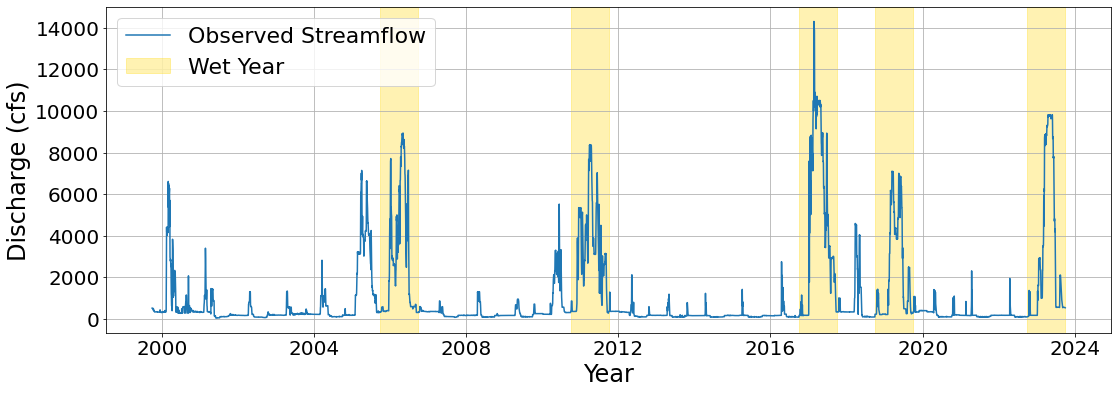

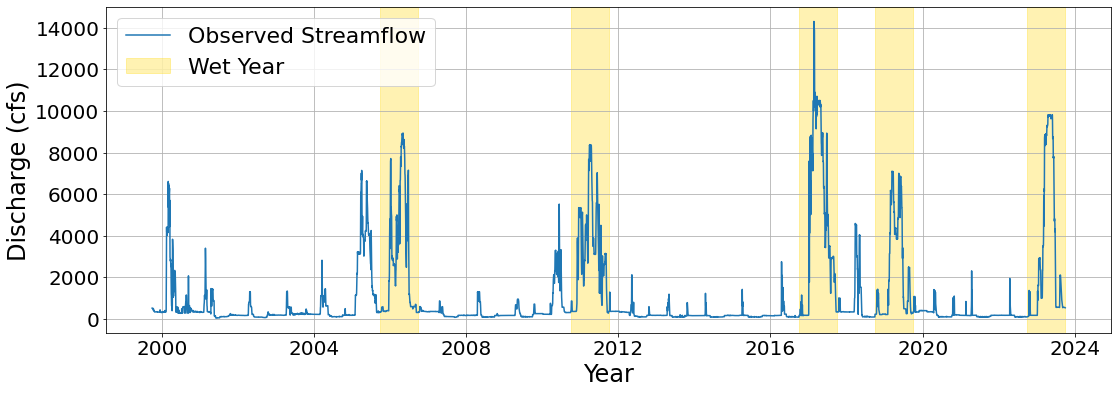

In [479]:
def plot_timeseries_daily_threshold(df):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,6))
    ax.plot(df['flow_cfs'], label=f'Observed Streamflow')
    #ax.plot(df['threshold_cfs'], linestyle='--', label=f'Daily Threshold (p90)')
    #ax.plot(df_daily_threshold['hmf_cfs'], label='HMF')
    #ax.fill_between(x=df.index, y1=df['threshold_cfs'], y2= df['hmf_cfs']+df['threshold_cfs'], color='C2', label='HMF')
    #ax.plot(df_daily_threshold['hmf_cfs']+df['threshold_cfs'])
    
    highlight_start = '2005-10-01'
    highlight_end = '2006-09-30'
    plt.axvspan(highlight_start, highlight_end, color='gold', alpha=0.3, label='Wet Year')
    highlight_start = '2010-10-01'
    highlight_end = '2011-09-30'
    plt.axvspan(highlight_start, highlight_end, color='gold', alpha=0.3)
    highlight_start = '2016-10-01'
    highlight_end = '2017-09-30'
    plt.axvspan(highlight_start, highlight_end, color='gold', alpha=0.3)
    highlight_start = '2018-10-01'
    highlight_end = '2019-09-30'
    plt.axvspan(highlight_start, highlight_end, color='gold', alpha=0.3)
    highlight_start = '2022-10-01'
    highlight_end = '2023-09-30'
    plt.axvspan(highlight_start, highlight_end, color='gold', alpha=0.3)

    ax.set_xlabel('Year', fontsize=24)
    ax.set_ylabel('Discharge (cfs)', fontsize=24)
    #ax.set_title('HMF Above Daily 90th Percentile', fontsize=26)
    ax.tick_params(axis='both', which='major', labelsize=20)
    plt.legend(fontsize=22)
    
    file_name = 'C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows_ca\\data_analysis\\results\\figures\\timeseries\\streamflow\\Tuol\\obs_flow\\tuol_selected_wet_years.png'
    plt.savefig(file_name, bbox_inches="tight")
    plt.show()
    return

plot_timeseries_daily_threshold(df_daily_threshold)
plot_timeseries_daily_threshold(df_daily_threshold_capped)

In [396]:
# # Sample 90/20 rule figure
# # HMF using daily thresholds - not capped at 20% daily flow
# site_no = '11335000'
# df = download_usgs_data(site_no, start_date, end_date)
# df = add_datetime_data(df)
# daily_threshold_dict_sorted, df_daily_threshold_no_hmf = calc_daily_threshold(df, percentile)
# df_daily_threshold = calc_daily_hmf(df_daily_threshold_no_hmf)

# # HMF using daily thresholds - capped at 20% daily flow
# df_daily_threshold_capped = calc_daily_hmf_capped(df_daily_threshold_no_hmf.copy())

# def plot_single_year_hydrograph(df: pd.DataFrame, option: int, WY):
#     #plt.rcParams['axes.grid'] = True
    
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 12))

#     # Plot daily, hmf, daily 90th percentile threshold streamflow for singular gauge
#     # Daily streamflow
#     selected_df = df[df['WY'] == WY] # only select rows associated with WY of each loop
#     selected_df = selected_df.reset_index()
#     #print(selected_df)
#     ax.plot(selected_df['datetime'], selected_df['flow_cfs'], color='C0', label=f'Observed Streamflow')

#     if option == 1:
#         # Option 1: Record threshold HMF
#         ax.axhline(y = threshold, linestyle='--', color='C0', label=f'Record 90th Percentile')
#         ax.fill_between(x=selected_df['datetime'], y1=threshold, y2= selected_df['hmf_cfs']+threshold, 
#             color='C1', alpha=0.5) #label=f'HMF ({site_name[j]})')

#     elif option == 2:
#         # Option 2: Median wet-season flow threshold HMF
#         ax.axhline(y = threshold_dict['median_wet_seas_flow_50'], linestyle='--', color='C1', label=f'Median Wet-Season Flow')
#         ax.fill_between(x=selected_df['datetime'], y1=threshold_dict['median_wet_seas_flow_50'], y2= selected_df['hmf_cfs']+threshold_dict['median_wet_seas_flow_50'], 
#             color='C1', alpha=0.5) #label=f'HMF ({site_name[j]})')

#     elif option == 3:
#         # Option 3: Daily threshold HMF
#         ax.plot(selected_df['datetime'], selected_df['threshold_cfs'], linestyle='--', color='red', alpha=0.8, label=f'Daily 90th Percentile')
#         ax.fill_between(x=selected_df['datetime'], y1=selected_df['threshold_cfs'], y2= selected_df['hmf_cfs_no_cap']+selected_df['threshold_cfs'], 
#             color='C1', alpha=0.2, label='HMF (No Max)')        
#         ax.fill_between(x=selected_df['datetime'], y1=selected_df['threshold_cfs'], y2= selected_df['hmf_cfs']+selected_df['threshold_cfs'], 
#             color='C1', alpha=0.5, label=f'HMF (Max 20% Divsion)')
        
#     #ax.plot(selected_df['datetime'], selected_df['hmf_cfs']+selected_df['threshold_cfs'], color='red', linestyle='--', alpha=0.8, label=f'HMF')

#     # Plot verical lines for Dec 1 - March 31
#     #plt.axvline(x = 62, linestyle='--', color='black')
#     #plt.axvline(x = 183, linestyle='--', color='black')
#     #plt.text(60, 5000, 'December 1', color = 'black', rotation = 90, rotation_mode = 'anchor', fontsize = 14)
#     #plt.text(181, 5000, 'March 31', color = 'black', rotation = 90, rotation_mode = 'anchor', fontsize = 14)

#     # Plot legend
#     ax.legend(bbox_to_anchor=(1.06, 1), loc='upper right', fontsize=22)

#     # Plot month names instead of numerical dates
#     plt.gca().xaxis.set_major_locator(MonthLocator(interval=2))
#     plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))  # %b for month abbreviation

#     # Add title to plot
#     fig.suptitle(f'Water Year: {WY}', fontsize=26)

#     # Edit tick and axis properties
#     ax.tick_params(axis='both', which='major', labelsize=24)
#     #ax.set_ylabel(f'Discharge (MAF/day)')
#     ax.set_ylabel(f'Discharge (cfs)', fontsize=26)
#     #ax.set_xlabel(f'DOHY', fontsize=20)

#     # Remove border
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.spines['left'].set_visible(False)

#     #ax.set_ylabel(f'Discharge (MAF/day)')
#     plt.tight_layout(rect=[0, 0.20, 1, 0.95])
#     file_name = 'C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows_ca\\data_analysis\\results\\figures\\timeseries\\streamflow\\Tuol\\obs_flow\\cosumnes_obs_flow_sample9020.png'
#     plt.savefig(file_name, bbox_inches="tight")
#     plt.show()
    
#     return 

# WY = 2019
# plot_single_year_hydrograph(df_daily_threshold_capped, 3, str(WY))

### HMF metrics using RECORD threshold (not capped and capped at 20% daily flow)

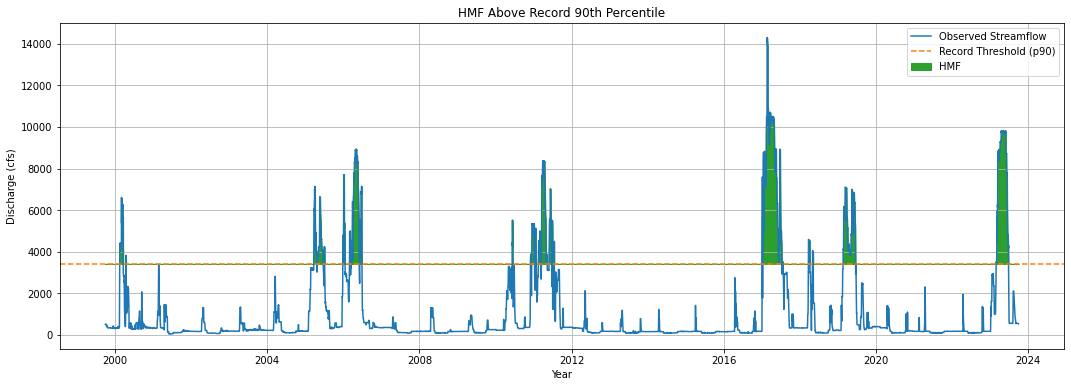

Annual Average Magnitude Above Daily Threshold:  0.58 MAF/year
Annual Average Magnitude Above Daily Threshold (Capped at 20% Daily Flow):  0.23 MAF/year
Annual Average Duration Above Daily Threshold:  97.44 days/year
Annual Average Event Magnitude Above Daily Threshold:  0.7 MAF/year
Annual Average Event Duration Above Daily Threshold:  38.9 days/event
Average Intra-Annual Frequency Above Daily Threshold:  3.2 events/year
Annual Inter-Annual Frequency Above Daily Threshold:  37.5 %


C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:245: RuntimeWarning: invalid value encountered in double_scalars


In [489]:
# HMF using record threshold - not capped at 20% daily flow
df = download_usgs_data(site_no, start_date, end_date)
df = add_datetime_data(df)
threshold = calc_record_threshold(df, percentile)
df_record_threshold = calc_record_hmf(df.copy(), threshold)

# HMF using record threshold - capped at 20% daily flow
df_record_threshold_capped = calc_record_hmf_capped(df.copy(), threshold)

def plot_timeseries_record_threshold(df):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,6))
    ax.plot(df['flow_cfs'], label=f'Observed Streamflow')
    #ax.plot(hmf_record_threshold['hmf_cfs']+threshold)
    ax.axhline(y = threshold, linestyle='--', label=f'Record Threshold (p90)', color='C1')
    ax.fill_between(df.index, y1=threshold, y2=df['hmf_cfs']+threshold, color='C2', label='HMF')

    ax.set_xlabel('Year')
    ax.set_ylabel('Discharge (cfs)')
    ax.set_title('HMF Above Record 90th Percentile')

    plt.legend()
    plt.show()
    return

plot_timeseries_record_threshold(df_record_threshold)

# Annual magnitude
annual_mag_series_daily_thres = calc_mag_maf(df_record_threshold)
annual_avg_mag_daily_thres = calc_zero_deflated_mean(annual_mag_series_daily_thres)
print(f'Annual Average Magnitude Above Daily Threshold: {annual_avg_mag_daily_thres: 0.2f} MAF/year')

annual_mag_series_daily_thres = calc_mag_maf(df_record_threshold_capped)
annual_avg_mag_daily_thres = calc_zero_deflated_mean(annual_mag_series_daily_thres)
print(f'Annual Average Magnitude Above Daily Threshold (Capped at 20% Daily Flow): {annual_avg_mag_daily_thres: 0.2f} MAF/year')

# Annual duration
annual_dur_series_daily_thres = calc_annual_dur(df_record_threshold)
annual_avg_dur_daily_thres = calc_zero_deflated_mean(annual_dur_series_daily_thres)
print(f'Annual Average Duration Above Daily Threshold: {annual_avg_dur_daily_thres: 0.2f} days/year')

# Event magnitude
event_mag_series_daily_thres = calc_event_mag_event_dur_intra_annual_fre(df_record_threshold)[0]
avg_event_mag_daily_thres = calc_zero_deflated_mean(event_mag_series_daily_thres)
print(f'Annual Average Event Magnitude Above Daily Threshold: {avg_event_mag_daily_thres: 0.1f} MAF/year')

# Event duration
event_dur_series_daily_thres = calc_event_mag_event_dur_intra_annual_fre(df_record_threshold)[1]
avg_event_dur_daily_thres = calc_zero_deflated_mean(event_dur_series_daily_thres)
print(f'Annual Average Event Duration Above Daily Threshold: {avg_event_dur_daily_thres: 0.1f} days/event')

# Event frequency
intra_ann_fre_series_daily_thres = calc_event_mag_event_dur_intra_annual_fre(df_record_threshold)[2]
avg_intra_ann_fre_series_daily_thres = calc_zero_deflated_mean(intra_ann_fre_series_daily_thres)
print(f'Average Intra-Annual Frequency Above Daily Threshold: {avg_intra_ann_fre_series_daily_thres : 0.1f} events/year')

# Inter-annual frequency
annual_inter_ann_fre_daily_thres = calc_inter_ann_fre(df_record_threshold)
print(f'Annual Inter-Annual Frequency Above Daily Threshold: {annual_inter_ann_fre_daily_thres: 0.1f} %')

# # Timing
# annual_tim_series_rec_thres = calc_tim(df_record_threshold)
# annual_avg_tim_rec_thres = calc_zero_deflated_mean(annual_tim_series_rec_thres)
# print(f'Annual Average COM Above Daily Threshold: {annual_avg_tim_rec_thres: 0.1f} DOHY')

# Data for box plots
data_rec_thres, summary_rec_thres = create_summary_table(df_record_threshold)
data_rec_thres_capped, summary_rec_thres_capped = create_summary_table(df_record_threshold_capped)

In [490]:
summary_rec_thres

,mag_maf,annual_dur,event_mag,event_dur,intra_annual_fre,timing
count,9,9,9,9,9,9
mean,0.575155,97.4444,0.736699,38.9012,3.22222,198.57
std,0.56428,59.8834,0.63327,34.3804,2.48452,25.6195
min,0.0123769,6,0.249043,6,1,159.572
25%,0.112641,38,0.351563,17.1111,2,180.472
50%,0.477055,119,0.45522,21.6667,2,200.781
75%,0.72843,130,0.822215,60.5,3,210.062
max,1.83879,195,2.34081,119,9,254.507


In [369]:
# # Boxplot generation (data_daily_thres or data_rec_thres)
# cols = data_rec_thres.columns
# ticks = ['Annual Magntidue', 'Annual Duration', 'Event Magnitude', 'Event Duration', 'Intra-Annual \n Frequency']
# #WYTs = ['Wet', 'Moderate', 'Dry']
# #yaxes = 'Discharge (cfs)'
# yaxes = ['MAF/Year', 'Days/Year', 'MAF/Event', 'Days/Event', 'Events/Year']
# color_list = ['C0', 'lightblue', 'seagreen', 'navy', 'yellow', 'coral']
# alpha_list = [0.8, 0.8, 0.8, 0.7, 0.8, 0.8]

# #fig, ax = plt.subplots(figsize=(20,6))

# #data_obs_4mo[data_obs_4mo[col] != 0][col]

# for j, col in enumerate(cols):
#     fig, ax = plt.subplots(figsize=(5,6))
#     #data[data[j] != 0][j]
#     ax.boxplot(data_daily_thres[data_daily_thres[col] != 0][col], positions=[0], widths=0.6, patch_artist=True,
#             boxprops=dict(facecolor=color_list[j], alpha=alpha_list[j]), 
#             medianprops=dict(color='#000000'),
#             showmeans=True, meanprops={"marker":"x", "markeredgecolor":"black", "markersize":"10"})
#     ax.set_ylabel(yaxes[j], fontsize=24)
#     ax.tick_params(axis='y', labelsize=20)
#     ax.set_xticklabels([ticks[j]], fontsize=24)
    
# #ax.set_xticklabels('label', fontsize=24)

# # customize plot
# #plt.xticks('label', fontsize=24)
# #ax.set_xticks([-1,0], ticks)
# #ax.set_ylabel(yaxes, fontsize=24)
# #plt.xlim(-2, len(ticks)*3)
# #plt.ylim(0, 1)
# #plt.title(f'HMF Metrics', fontsize=26)
# plt.tight_layout()

# # ax.spines['top'].set_visible(False)
# # ax.spines['right'].set_visible(False)
# # ax.spines['bottom'].set_visible(False)
# # ax.spines['left'].set_visible(False)

# file_name = f'../results/figures/box_plots/tuol_compare_flows_by_annual_flow_types.png'
# plt.savefig(file_name, bbox_inches="tight")
# plt.show()

### Dictionary of alternate thresholds

In [400]:
# Calculate thresholds and save to a dictionary
threshold_dict = calc_thresholds_flow(site_no, start_date, end_date, percentile)
print(threshold_dict)

{'p90': 3415.0, 'median_wet_seas_flow_10': 1810, 'median_wet_seas_flow_50': 3130, 'median_wet_seas_flow_90': 5110, '2yr_event': 2943.4989115753797, '3yr_event': 4203.378706888445, '5yr_event': 5990.192798872149, '10yr_event': 8892.874888099179, 'flood_DWR': 8500, 'peak_2yr_10': 9380}


### HMF metrics for SELECTED threshold (not capped and capped 20% of daily flow)

In [491]:
# HMF using median wet season flow (50 pctl) threshold - not capped at 20% daily flow
dict_threshold = 'median_wet_seas_flow_50'
df = download_usgs_data(site_no, start_date, end_date)
df = add_datetime_data(df)
threshold_selected = threshold_dict[dict_threshold]
df_selected_threshold = calc_record_hmf(df.copy(), threshold_selected)

# HMF using median wet season flow (50 pctl) threshold - capped at 20% daily flow
df_selected_threshold_capped = calc_record_hmf_capped(df.copy(), threshold_selected)

# Data for box plots
data_selected_thres, summary_selected_thres = create_summary_table(df_selected_threshold)
data_selected_thres_capped, summary_selected_thres_capped = create_summary_table(df_selected_threshold_capped)

C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:245: RuntimeWarning: invalid value encountered in double_scalars


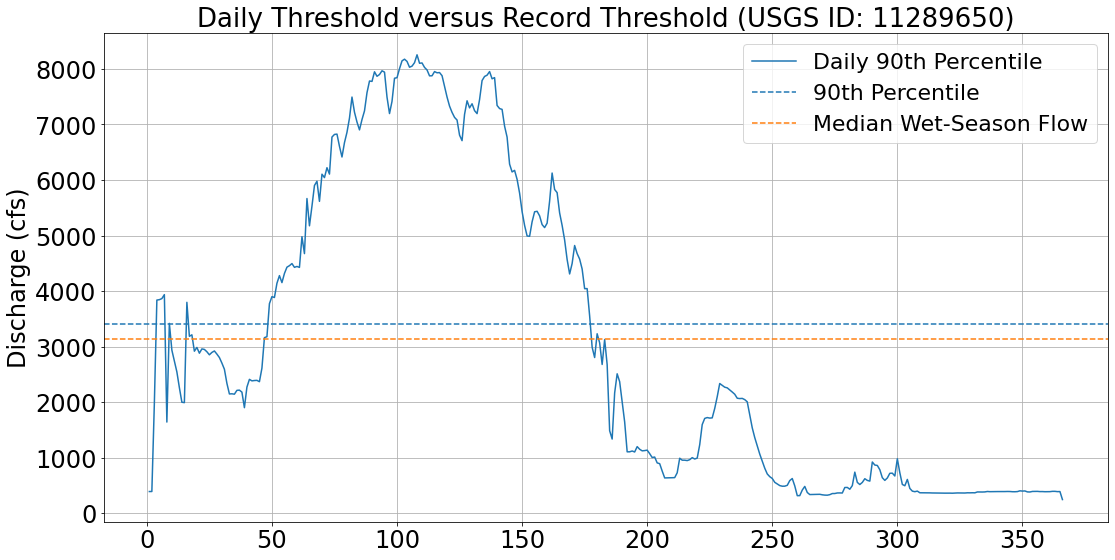

In [406]:
# Plot of thresholds
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,9))
ax.plot(list(daily_threshold_dict_sorted.keys()), list(daily_threshold_dict_sorted.values()), label=f'Daily 90th Percentile')
ax.axhline(y = threshold, linestyle='--', color='C0', label=f'90th Percentile')
ax.axhline(y = threshold_dict['median_wet_seas_flow_50'], linestyle='--', color='C1', label=f'Median Wet-Season Flow')
#ax.set_xlabel('DOY')
ax.set_ylabel('Discharge (cfs)', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_title(f'Daily Threshold versus Record Threshold (USGS ID: {site_no})', fontsize=26)
plt.legend(fontsize=22)
plt.show()

### Plot of all hydrographs, daily 90th percentile, and thresholds

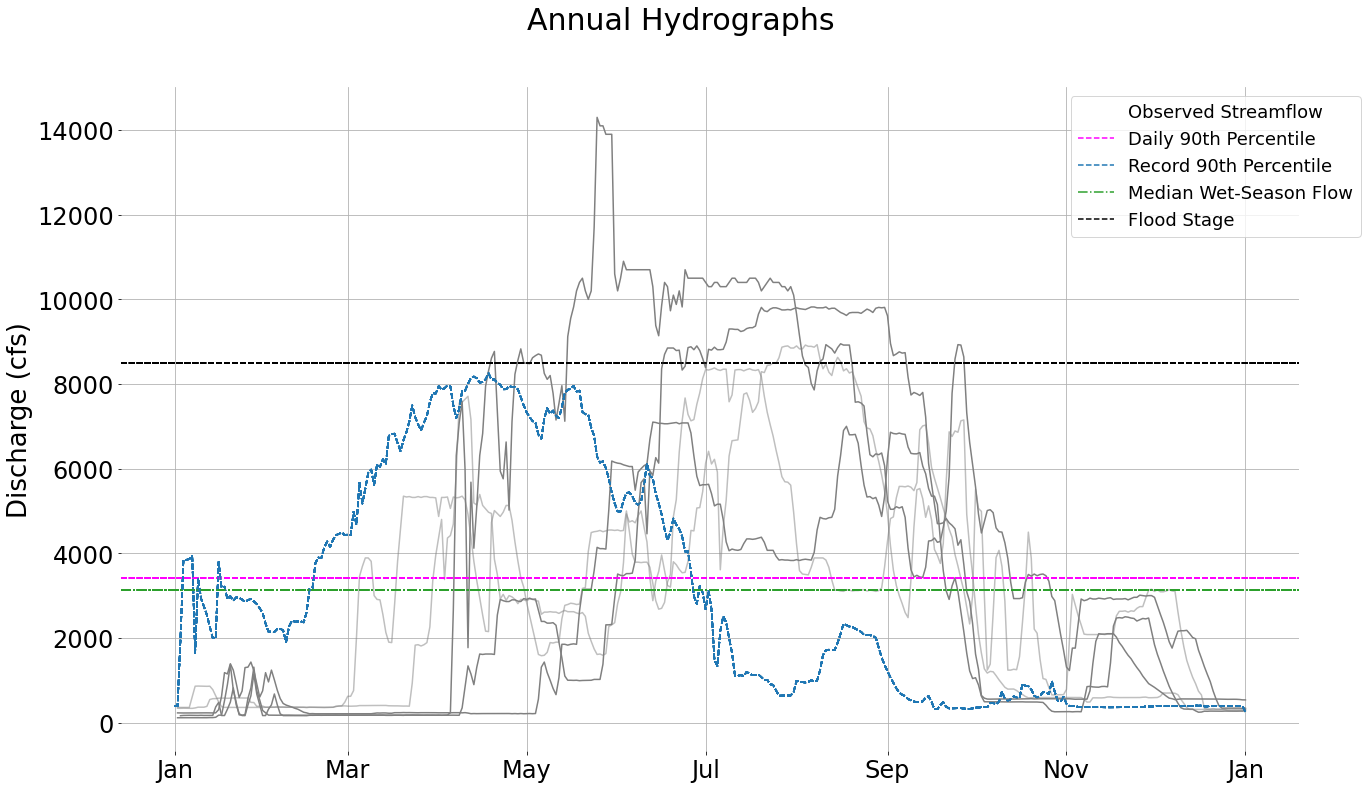

In [465]:
def plot_all_hydrographs(df: pd.DataFrame):
    ''' This code only runs when using df_daily_threshold, not the record threshold '''
    
    WYs = df['WY'].unique()
    #plt.rcParams['axes.grid'] = True
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(19, 14))
    
    for i, WY in enumerate(WYs):
    
        # Plot daily, hmf, daily 90th percentile threshold streamflow for singular gauge
        selected_df = df[df['WY'] == WY] # only select rows associated with WY of each loop
        selected_df = selected_df.reset_index()
        #print(selected_df)
        if WY == '2006':
            ax.plot(selected_df['DOHY'], selected_df['flow_cfs'], color='grey', alpha=0.5)
        elif WY == '2011':
            ax.plot(selected_df['DOHY'], selected_df['flow_cfs'], color='grey', alpha=0.5)
        elif WY == '2017':
            ax.plot(selected_df['DOHY'], selected_df['flow_cfs'], color='grey')        
        elif WY == '2019':
            ax.plot(selected_df['DOHY'], selected_df['flow_cfs'], color='grey')
        elif WY == '2023':
            ax.plot(selected_df['DOHY'], selected_df['flow_cfs'], color='grey')
        else:
            ax.plot(selected_df['DOHY'], selected_df['flow_cfs'], color='none')
            
        
        #ax.plot(selected_df['DOHY'], selected_df['hmf_cfs']+selected_df['threshold_cfs'], color='C1', label=f'HMF')
        ax.axhline(y = threshold, linestyle='--', color='magenta')#, label=f'Record 90th Percentile')
        ax.plot(list(daily_threshold_dict_sorted.values()), linestyle='--', color='C0')
        #ax.plot(selected_df['DOHY'][366:731], selected_df['threshold_cfs'], linestyle='--', color='C1') # label=f'Daily 90th Percentile'
        ax.axhline(y = threshold_dict['median_wet_seas_flow_50'], linestyle='-.', color='C2') # label=f'Median Wet-Season Flow'
        #ax.axhline(y = threshold_dict['2yr_event'], linestyle='--', color='C3') # label=f'2-Year Return Event'
        #ax.axhline(y = threshold_dict['5yr_event'], linestyle='--', color='C4') # label=f'5-Year Return Event'
        ax.axhline(y = threshold_dict['flood_DWR'], linestyle='--', color='black') # label=f'5-Year Return Event'
        #ax.axhline(y = threshold_dict['peak_2yr_10'], linestyle='--', color='C6') # label=f'2-Year Peak Event'
        #ax.fill_between(x=selected_df['DOHY'], y1=selected_df['threshold_cfs'], y2= selected_df['hmf_cfs']+selected_df['threshold_cfs'], 
         #       color='C1', alpha=0.5) #label=f'HMF ({site_name[j]})')
    
    # Plot month names instead of numerical dates
    plt.gca().xaxis.set_major_locator(MonthLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))  # %b for month abbreviation
    
    # Plot verical lines for Dec 1 - March 31
    # plt.axvline(x = 62, linestyle='--', color='black', label = 'December 1')
    # plt.axvline(x = 183, linestyle='--', color='black', label = 'March 31')
    # plt.axvline(x = 273, linestyle='--', color='black', label = 'July 1')
    # plt.text(60, 11000, 'December 1', color = 'black', rotation = 90, rotation_mode = 'anchor', fontsize = 14)
    # plt.text(181, 11000, 'March 31', color = 'black', rotation = 90, rotation_mode = 'anchor', fontsize = 14)
    # plt.text(271, 11000, 'July 1', color = 'black', rotation = 90, rotation_mode = 'anchor', fontsize = 14)
    
    # Plot legend
    #ax.legend(bbox_to_anchor=(1.06, 1), loc='upper right', fontsize=22)
    #ax.legend(['Observed Streamflow', 'Record 90th Percentile', 'Daily 90th Percentile', 'Median Wet-Season Flow', '2-Year Return Event', '5-Year Return Event', 'Flood Stage', '2-Year Peak Event'], 
    #          bbox_to_anchor=(1.06, 1), loc='upper right', fontsize=18)
    #ax.legend(['Observed Streamflow', 'Record 90th Percentile', 'Daily 90th Percentile', '2-Year Return Event', '5-Year Return Event'], 
    #           bbox_to_anchor=(1.06, 1), loc='upper right', fontsize=18)
    ax.legend(['Observed Streamflow', 'Daily 90th Percentile', 'Record 90th Percentile', 'Median Wet-Season Flow', 'Flood Stage'], 
               bbox_to_anchor=(1.06, 1), loc='upper right', fontsize=18)

    # Add title to plot
    fig.suptitle(f'Annual Hydrographs', fontsize=30)

    # Edit tick and axis properties
    ax.tick_params(axis='both', which='major', labelsize=24)
    #ax.set_ylabel(f'Discharge (MAF/day)')
    ax.set_ylabel(f'Discharge (cfs)', fontsize=26)
    #ax.set_xlabel(f'DOHY', fontsize=26)

    # Remove border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    #ax.set_ylabel(f'Discharge (MAF/day)')
    plt.tight_layout(rect=[0, 0.20, 1, 0.95])
    file_name = 'C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows_ca\\data_analysis\\results\\figures\\timeseries\\streamflow\\Tuol\\obs_flow\\tuol_daily_thres_'+str(site_no)+'.png'
    plt.savefig(file_name, bbox_inches="tight")
    plt.show()
    
    return 

plot_all_hydrographs(df_daily_threshold)

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,6))
# #ax.plot(df['DOHY'], df['threshold_cfs'])
# ax.plot(list(daily_threshold_dict_sorted.keys()), list(daily_threshold_dict_sorted.values()))
# ax.plot(df['DOY'], df['flow_cfs'])
# plt.show()

In [426]:
WY = '2006'
df_2006 = df[df['WY'] == WY]
#selected_df['peak_flow'] = [flow if flow > 6000 else 0 for flow in selected_df['flow_cfs']]
peak_start_date = df_2006[df_2006['flow_cfs'] > 6000].index.tolist()[0]

# Winter peak flows
peak_flow_timestamps = []
for i in range(0, 10):
    next_timestamp = peak_start_date + timedelta(days=i)
    peak_flow_timestamps.append(next_timestamp)
    
df_2006['peak_flow'] = df_2006['flow_cfs'].where(df_2006.index.isin(peak_flow_timestamps), 0)

# Spring recession flows
spr_rec_start_date = pd.Timestamp(WY+'-05-01')

spr_rec_timestamps = []
for i in range(0, 30):
    next_timestamp = spr_rec_start_date + timedelta(days=i)
    spr_rec_timestamps.append(next_timestamp)
    
df_2006['spr_rec_flow'] = df_2006['flow_cfs'].where(df_2006.index.isin(spr_rec_timestamps), 0)

# Generate new ffs
df_2006['flow_cfs_ff'] = np.where(df_2006.index.isin(peak_flow_timestamps + spr_rec_timestamps), 0, df_2006['flow_cfs'])

C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

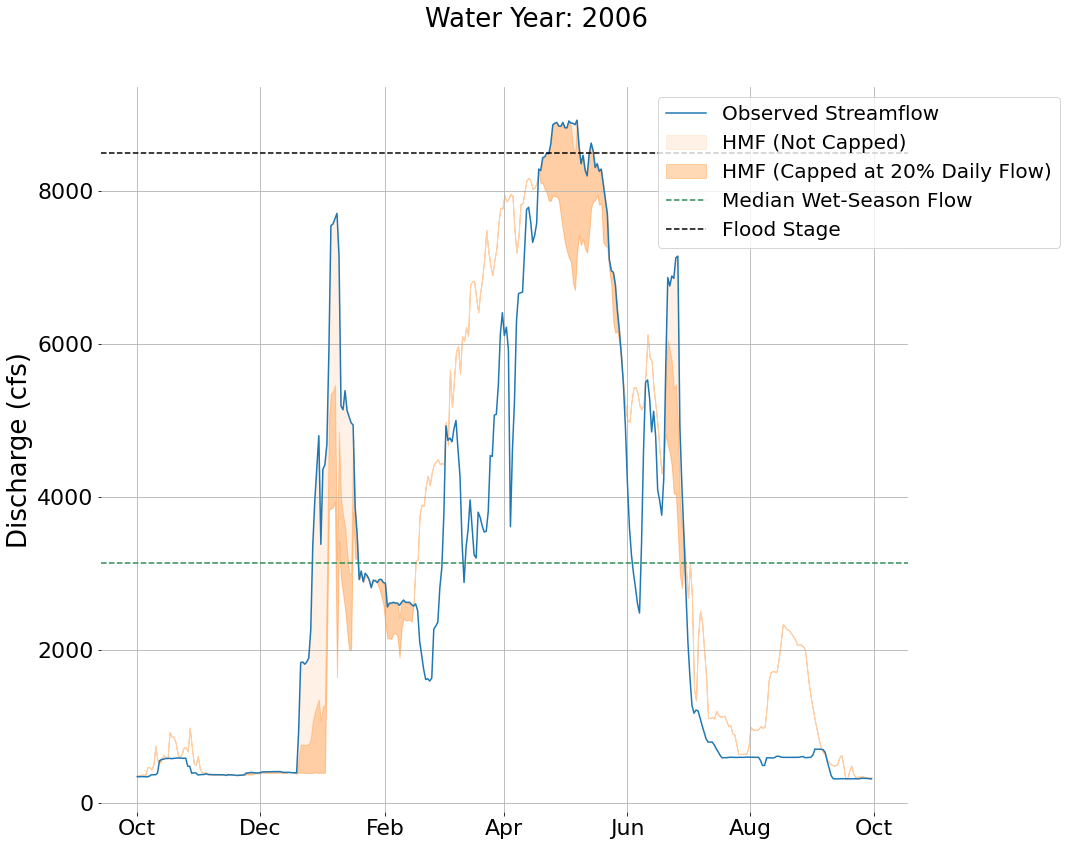

In [508]:
from datetime import datetime
def plot_single_year_hydrograph(df: pd.DataFrame, option: int, WY):
    #plt.rcParams['axes.grid'] = True
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

    # Plot daily, hmf, daily 90th percentile threshold streamflow for singular gauge
    # Daily streamflow
    selected_df = df[df['WY'] == WY] # only select rows associated with WY of each loop
    selected_df = selected_df.reset_index()
    #print(selected_df)
    ax.plot(selected_df['datetime'], selected_df['flow_cfs'], color='C0', label=f'Observed Streamflow')

    if option == 1:
        # Option 1: Record threshold HMF
        ax.axhline(y = threshold, linestyle='--', color='C0', label=f'Record 90th Percentile')
        ax.fill_between(x=selected_df['datetime'], y1=threshold, y2= selected_df['hmf_cfs']+threshold, 
            color='C1', alpha=0.5) #label=f'HMF ({site_name[j]})')

    elif option == 2:
        # Option 2: Median wet-season flow threshold HMF
        ax.axhline(y = threshold_dict['median_wet_seas_flow_50'], linestyle='--', color='seagreen', label=f'Median Wet-Season Flow')
        ax.fill_between(x=selected_df['datetime'], y1=threshold_dict['median_wet_seas_flow_50'], y2= selected_df['hmf_cfs']+threshold_dict['median_wet_seas_flow_50'], 
            color='C1', alpha=0.3, label=f'HMF')
        
        start_date = peak_flow_timestamps[0]
        end_date = peak_flow_timestamps[-1]
        df_2006['peak_flow'] = df_2006['peak_flow'].apply(lambda x: threshold_dict['median_wet_seas_flow_50'] if x == 0 else x)
        #ax.plot(df_2006['peak_flow'])
        ax.fill_between(x=df_2006.index, y1=threshold_dict['median_wet_seas_flow_50'], y2= df_2006['peak_flow'], 
                        #where=(selected_df.index >= datetime.fromtimestamp(start_date)) & (selected_df.index <= datetime.fromtimestamp(end_date)),
                        color='seagreen', alpha=0.5, label=f'Functional Flows')
        
        start_date = spr_rec_timestamps[0]
        end_date = spr_rec_timestamps[-1]
        df_2006['spr_rec_flow'] = df_2006['spr_rec_flow'].apply(lambda x: threshold_dict['median_wet_seas_flow_50'] if x == 0 else x)
        #ax.plot(df_2006['peak_flow'])
        ax.fill_between(x=df_2006.index, y1=threshold_dict['median_wet_seas_flow_50'], y2= df_2006['spr_rec_flow'], 
                        #where=(selected_df.index >= datetime.fromtimestamp(start_date)) & (selected_df.index <= datetime.fromtimestamp(end_date)),
                        color='seagreen', alpha=0.5) #label=f'HMF ({site_name[j]})')

    elif option == 3:
        # Option 3: Daily threshold HMF
        #ax.plot(selected_df['datetime'], selected_df['threshold_cfs'], linestyle='--', color='C2', alpha=0.2, label=f'Daily 90th Percentile')
        ax.fill_between(x=selected_df['datetime'], y1=selected_df['threshold_cfs'], y2= selected_df['hmf_cfs_no_cap']+selected_df['threshold_cfs'], 
            color='C1', alpha=0.1, label='HMF (Not Capped)')        
        ax.fill_between(x=selected_df['datetime'], y1=selected_df['threshold_cfs'], y2= selected_df['hmf_cfs']+selected_df['threshold_cfs'], 
            color='C1', alpha=0.3, label=f'HMF (Capped at 20% Daily Flow)')
        ax.axhline(y = threshold_dict['median_wet_seas_flow_50'], linestyle='--', color='seagreen', label=f'Median Wet-Season Flow')
        
    #ax.plot(selected_df['datetime'], selected_df['hmf_cfs']+selected_df['threshold_cfs'], color='C1', linestyle='--', alpha=0.1, label=f'HMF')
    ax.axhline(y = threshold_dict['flood_DWR'], linestyle='--', color='black', label='Flood Stage')

    # Plot verical lines for Dec 1 - March 31
    #plt.axvline(x = 62, linestyle='--', color='black')
    #plt.axvline(x = 183, linestyle='--', color='black')
    #plt.text(60, 5000, 'December 1', color = 'black', rotation = 90, rotation_mode = 'anchor', fontsize = 14)
    #plt.text(181, 5000, 'March 31', color = 'black', rotation = 90, rotation_mode = 'anchor', fontsize = 14)

    # Plot legend
    ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', fontsize=20)

    # Plot month names instead of numerical dates
    plt.gca().xaxis.set_major_locator(MonthLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))  # %b for month abbreviation

    # Add title to plot
    fig.suptitle(f'Water Year: {WY}', fontsize=26)

    # Edit tick and axis properties
    ax.tick_params(axis='both', which='major', labelsize=22)
    #ax.set_ylabel(f'Discharge (MAF/day)')
    ax.set_ylabel(f'Discharge (cfs)', fontsize=26)
    #ax.set_xlabel(f'DOHY', fontsize=20)

    # Remove border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    #ax.set_ylabel(f'Discharge (MAF/day)')
    plt.tight_layout(rect=[0, 0.20, 1, 0.95])
    if option == 2:
        fig_name = 'ff'
    elif option == 3:
        fig_name = '9020_rule'
    file_name = f'C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows_ca\\data_analysis\\results\\figures\\timeseries\\streamflow\\Tuol\\obs_flow\\tuol_obs_flow_{fig_name}.png'
    plt.savefig(file_name, bbox_inches="tight")
    plt.show()
    
    return 

#plot_single_year_hydrograph(df_selected_threshold, 2, '2006')
#plot_single_year_hydrograph(df_selected_threshold_capped, 2, '2006')
plot_single_year_hydrograph(df_daily_threshold_capped, 3, '2006')

In [440]:
selected_df.index
spr_rec_timestamps[0]

Timestamp('2006-05-01 00:00:00')

### Plots of annual hydrographs

In [74]:
# Modify function below to plot flows about annual or daily threshold

def plot_annual_hydrographs(df: pd.DataFrame, option: int):
    
    WYs = df['WY'].unique()
    plt.rcParams['axes.grid'] = True
    
    for i, WY in enumerate(WYs):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
    
        # Plot daily, hmf, daily 90th percentile threshold streamflow for singular gauge
        # Daily streamflow
        selected_df = df[df['WY'] == WY] # only select rows associated with WY of each loop
        ax.plot(selected_df['DOHY'], selected_df['flow_cfs'], color='C0', label=f'Observed Streamflow')
        
        if option == 1:
            # Option 1: Record threshold HMF
            ax.axhline(y = threshold, linestyle='--', color='C0', label=f'Record 90th Percentile')
            ax.fill_between(x=selected_df['DOHY'], y1=threshold, y2= selected_df['hmf_cfs']+threshold, 
                color='C1', alpha=0.5) #label=f'HMF ({site_name[j]})')
        
        elif option == 2:
            # Option 2: Median wet-season flow threshold HMF
            ax.axhline(y = threshold_med_wet_seas, linestyle='--', color='C1', label=f'Median Wet-Season Flow')
            ax.fill_between(x=selected_df['DOHY'], y1=threshold_med_wet_seas, y2= selected_df['hmf_cfs']+threshold_med_wet_seas, 
                color='C1', alpha=0.5) #label=f'HMF ({site_name[j]})')
        
        elif option == 3:
            # Option 3: Daily threshold HMF
            ax.plot(selected_df['DOHY'], selected_df['threshold_cfs'], linestyle='--', color='C2', label=f'Daily 90th Percentile')
            ax.fill_between(x=selected_df['DOHY'], y1=selected_df['threshold_cfs'], y2= selected_df['hmf_cfs']+selected_df['threshold_cfs'], 
                color='C1', alpha=0.5) #label=f'HMF ({site_name[j]})')
        ax.plot(selected_df['DOHY'], selected_df['hmf_cfs']+selected_df['threshold_cfs'], color='C1', label=f'HMF')
        
        # Plot verical lines for Dec 1 - March 31
        plt.axvline(x = 62, linestyle='--', color='black')
        plt.axvline(x = 183, linestyle='--', color='black')
        plt.text(60, 5000, 'December 1', color = 'black', rotation = 90, rotation_mode = 'anchor', fontsize = 14)
        plt.text(181, 5000, 'March 31', color = 'black', rotation = 90, rotation_mode = 'anchor', fontsize = 14)
        
        # Plot legend
        ax.legend(bbox_to_anchor=(1.06, 1), loc='upper right', fontsize=18)

        # Plot month names instead of numerical dates
        #plt.gca().xaxis.set_major_locator(MonthLocator())
        #plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))  # %b for month abbreviation

        # Add title to plot
        fig.suptitle(f'Water Year: {WY}', fontsize=26)

        # Edit tick and axis properties
        ax.tick_params(axis='both', which='major', labelsize=18)
        #ax.set_ylabel(f'Discharge (MAF/day)')
        ax.set_ylabel(f'Discharge (cfs)', fontsize=20)
        ax.set_xlabel(f'DOHY', fontsize=20)

        # Remove border
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

        #ax.set_ylabel(f'Discharge (MAF/day)')
        plt.tight_layout(rect=[0, 0.20, 1, 0.95])
        #file_name = 'C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows\\data_analysis\\results\\figures\\timeseries\\streamflow\\Tuol\\obs_flow\\tuol_obs_flow'+str(site_id)+'_'+WY+'.png'
        #plt.savefig(file_name, bbox_inches="tight")
        plt.show()
    
    return 

# Option 1: Record threshold - 90th percentile
#plot_annual_hydrographs(df_record_threshold, 1)
#plot_annual_hydrographs(df_record_threshold_capped, 1)

# Option 2: Record threshold - wet season baseflow
#plot_annual_hydrographs(df_wet_seas_threshold, 2)
#plot_annual_hydrographs(df_wet_seas_threshold_capped, 2)

# Option 3: Daily threshold
#plot_annual_hydrographs(df_daily_threshold, 3)
#plot_annual_hydrographs(df_daily_threshold_capped, 3)

### Timeseries generation to remove functional flows

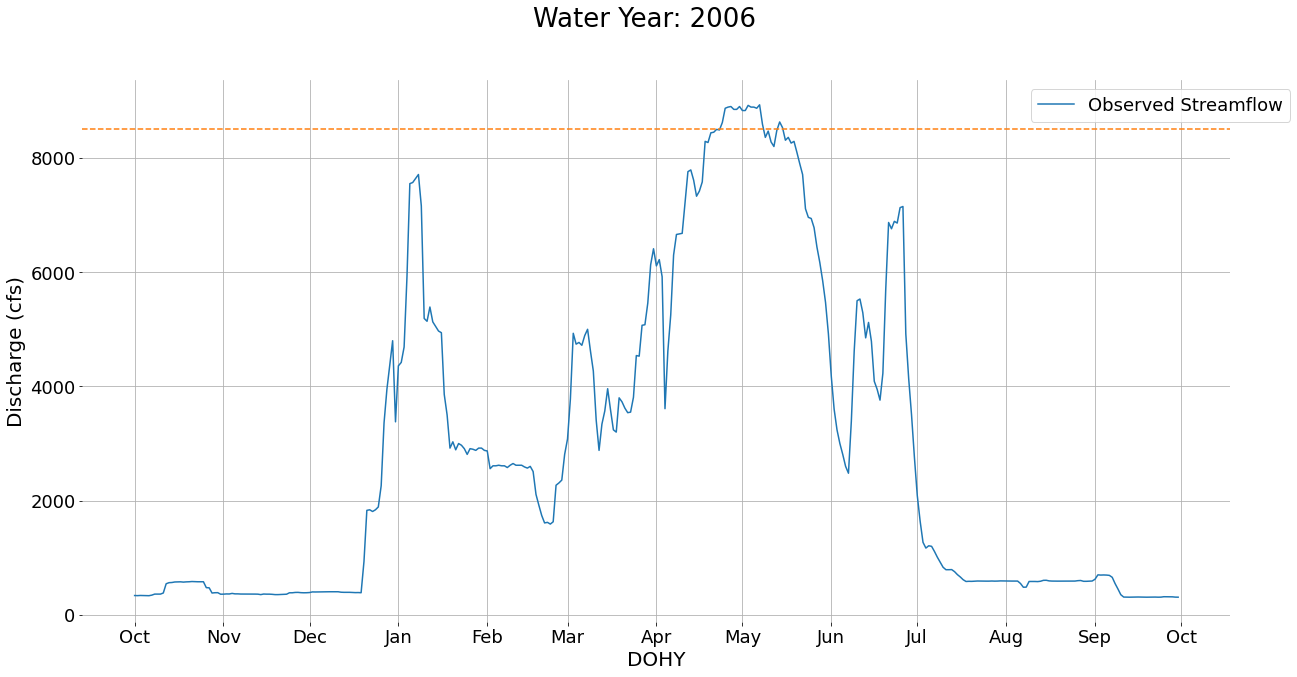

In [111]:
def plot_single_year_obs_flow(df: pd.DataFrame, WY):
    #plt.rcParams['axes.grid'] = True
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 12))

    # Plot daily, hmf, daily 90th percentile threshold streamflow for singular gauge
    # Daily streamflow
    selected_df = df[df['WY'] == WY] # only select rows associated with WY of each loop
    selected_df = selected_df.reset_index()
    #print(selected_df)
    ax.plot(selected_df['datetime'], selected_df['flow_cfs'], color='C0', label=f'Observed Streamflow')
    ax.axhline(y = threshold_dict['flood_DWR'], linestyle='--', color='C1')
    
    # Plot legend
    ax.legend(bbox_to_anchor=(1.06, 1), loc='upper right', fontsize=18)

    # Plot month names instead of numerical dates
    plt.gca().xaxis.set_major_locator(MonthLocator())
    plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))  # %b for month abbreviation

    # Add title to plot
    fig.suptitle(f'Water Year: {WY}', fontsize=26)

    # Edit tick and axis properties
    ax.tick_params(axis='both', which='major', labelsize=18)
    #ax.set_ylabel(f'Discharge (MAF/day)')
    ax.set_ylabel(f'Discharge (cfs)', fontsize=20)
    ax.set_xlabel(f'DOHY', fontsize=20)

    # Remove border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    #ax.set_ylabel(f'Discharge (MAF/day)')
    plt.tight_layout(rect=[0, 0.20, 1, 0.95])
    #file_name = 'C:\\Users\\kondr\\Documents\\Research\\high_magnitude_flows\\data_analysis\\results\\figures\\timeseries\\streamflow\\Tuol\\obs_flow\\tuol_obs_flow'+str(site_id)+'_'+WY+'.png'
    #plt.savefig(file_name, bbox_inches="tight")
    plt.show()
    
    return 

plot_single_year_obs_flow(df, '2006')

C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

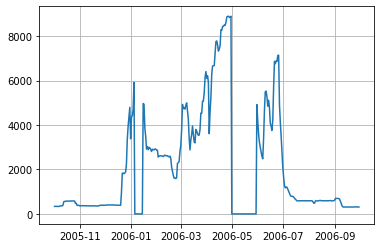

In [418]:
WY = '2006'
df_2006 = df[df['WY'] == WY]
#selected_df['peak_flow'] = [flow if flow > 6000 else 0 for flow in selected_df['flow_cfs']]
peak_start_date = df_2006[df_2006['flow_cfs'] > 6000].index.tolist()[0]

# Winter peak flows
peak_flow_timestamps = []
for i in range(0, 10):
    next_timestamp = peak_start_date + timedelta(days=i)
    peak_flow_timestamps.append(next_timestamp)
    
df_2006['peak_flow'] = df_2006['flow_cfs'].where(df_2006.index.isin(peak_flow_timestamps), 0)

# Spring recession flows
spr_rec_start_date = pd.Timestamp(WY+'-05-01')

spr_rec_timestamps = []
for i in range(0, 30):
    next_timestamp = spr_rec_start_date + timedelta(days=i)
    spr_rec_timestamps.append(next_timestamp)
    
df_2006['spr_rec_flow'] = df_2006['flow_cfs'].where(df_2006.index.isin(spr_rec_timestamps), 0)

# Generate new ffs
df_2006['flow_cfs_ff'] = np.where(df_2006.index.isin(peak_flow_timestamps + spr_rec_timestamps), 0, df_2006['flow_cfs'])
plt.plot(df_2006['flow_cfs_ff'])

C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

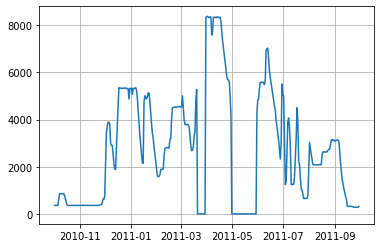

In [274]:
WY = '2011'
df_2011 = df[df['WY'] == WY]
#selected_df['peak_flow'] = [flow if flow > 6000 else 0 for flow in selected_df['flow_cfs']]
peak_start_date = df_2011[df_2011['flow_cfs'] > 6000].index.tolist()[0]

# Winter peak flows
peak_flow_timestamps = []
for i in range(0, 10):
    next_timestamp = peak_start_date + timedelta(days=i)
    peak_flow_timestamps.append(next_timestamp)
    
df_2011['peak_flow'] = df_2011['flow_cfs'].where(df_2011.index.isin(peak_flow_timestamps), 0)

# Spring recession flows
spr_rec_start_date = pd.Timestamp(WY+'-05-01')

spr_rec_timestamps = []
for i in range(0, 30):
    next_timestamp = spr_rec_start_date + timedelta(days=i)
    spr_rec_timestamps.append(next_timestamp)
    
df_2011['spr_rec_flow'] = df_2011['flow_cfs'].where(df_2011.index.isin(spr_rec_timestamps), 0)

# Generate new ffs
df_2011['flow_cfs_ff'] = np.where(df_2011.index.isin(peak_flow_timestamps + spr_rec_timestamps), 0, df_2011['flow_cfs'])
plt.plot(df_2011['flow_cfs_ff'])

C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

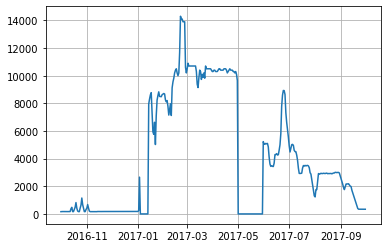

In [275]:
WY = '2017'
df_2017 = df[df['WY'] == WY]
#selected_df['peak_flow'] = [flow if flow > 6000 else 0 for flow in selected_df['flow_cfs']]
peak_start_date = df_2017[df_2017['flow_cfs'] > 6000].index.tolist()[0]

# Winter peak flows
peak_flow_timestamps = []
for i in range(0, 10):
    next_timestamp = peak_start_date + timedelta(days=i)
    peak_flow_timestamps.append(next_timestamp)
    
df_2017['peak_flow'] = df_2017['flow_cfs'].where(df_2017.index.isin(peak_flow_timestamps), 0)

# Spring recession flows
spr_rec_start_date = pd.Timestamp(WY+'-05-01')

spr_rec_timestamps = []
for i in range(0, 30):
    next_timestamp = spr_rec_start_date + timedelta(days=i)
    spr_rec_timestamps.append(next_timestamp)
    
df_2017['spr_rec_flow'] = df_2017['flow_cfs'].where(df_2017.index.isin(spr_rec_timestamps), 0)

# Generate new ffs
df_2017['flow_cfs_ff'] = np.where(df_2017.index.isin(peak_flow_timestamps + spr_rec_timestamps), 0, df_2017['flow_cfs'])
plt.plot(df_2017['flow_cfs_ff'])

C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

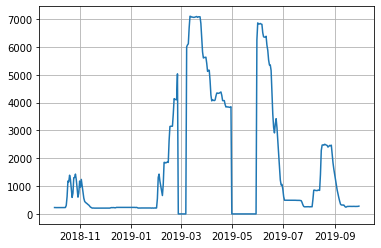

In [276]:
WY = '2019'
df_2019 = df[df['WY'] == WY]
#selected_df['peak_flow'] = [flow if flow > 6000 else 0 for flow in selected_df['flow_cfs']]
peak_start_date = df_2019[df_2019['flow_cfs'] > 6000].index.tolist()[0]

# Winter peak flows
peak_flow_timestamps = []
for i in range(0, 10):
    next_timestamp = peak_start_date + timedelta(days=i)
    peak_flow_timestamps.append(next_timestamp)
    
df_2019['peak_flow'] = df_2019['flow_cfs'].where(df_2019.index.isin(peak_flow_timestamps), 0)

# Spring recession flows
spr_rec_start_date = pd.Timestamp(WY+'-05-01')

spr_rec_timestamps = []
for i in range(0, 30):
    next_timestamp = spr_rec_start_date + timedelta(days=i)
    spr_rec_timestamps.append(next_timestamp)
    
df_2019['spr_rec_flow'] = df_2019['flow_cfs'].where(df_2019.index.isin(spr_rec_timestamps), 0)

# Generate new ffs
df_2019['flow_cfs_ff'] = np.where(df_2019.index.isin(peak_flow_timestamps + spr_rec_timestamps), 0, df_2019['flow_cfs'])
plt.plot(df_2019['flow_cfs_ff'])

C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

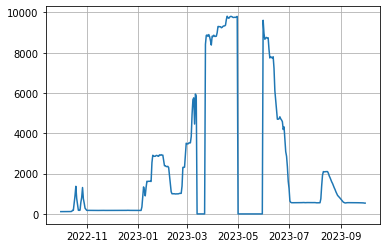

In [277]:
WY = '2023'
df_2023 = df[df['WY'] == WY]
#selected_df['peak_flow'] = [flow if flow > 6000 else 0 for flow in selected_df['flow_cfs']]
peak_start_date = df_2023[df_2023['flow_cfs'] > 6000].index.tolist()[0]

# Winter peak flows
peak_flow_timestamps = []
for i in range(0, 10):
    next_timestamp = peak_start_date + timedelta(days=i)
    peak_flow_timestamps.append(next_timestamp)
    
df_2023['peak_flow'] = df_2023['flow_cfs'].where(df_2023.index.isin(peak_flow_timestamps), 0)

# Spring recession flows
spr_rec_start_date = pd.Timestamp(WY+'-05-01')

spr_rec_timestamps = []
for i in range(0, 30):
    next_timestamp = spr_rec_start_date + timedelta(days=i)
    spr_rec_timestamps.append(next_timestamp)
    
df_2023['spr_rec_flow'] = df_2023['flow_cfs'].where(df_2023.index.isin(spr_rec_timestamps), 0)

# Generate new ffs
df_2023['flow_cfs_ff'] = np.where(df_2023.index.isin(peak_flow_timestamps + spr_rec_timestamps), 0, df_2023['flow_cfs'])
plt.plot(df_2023['flow_cfs_ff'])

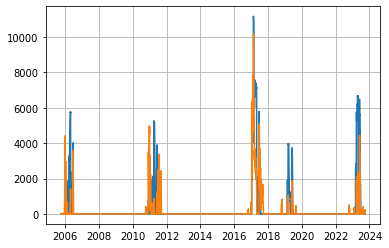

In [341]:
# Statistics for all dfs
df_wet_yrs = pd.concat([df_2006, df_2011, df_2017, df_2019, df_2023], axis=0)
df_wet_yrs_ff = df_wet_yrs.drop('flow_cfs', axis=1)
df_wet_yrs_ff = df_wet_yrs_ff.rename(columns={'flow_cfs_ff': 'flow_cfs'})

# OPTIONS 1 and 2: FLOW ABOVE MEDIAN WET SEASON, CAPPED AND UNCAPPED
dict_threshold = 'median_wet_seas_flow_50'
threshold_selected = threshold_dict[dict_threshold]
df_selected_threshold_ff = calc_record_hmf(df_wet_yrs_ff.copy(), threshold_selected)

# HMF using median wet season flow (50 pctl) threshold - capped at 20% daily flow
df_selected_threshold_capped_ff = calc_record_hmf_capped(df_wet_yrs_ff.copy(), threshold_selected)

plt.plot(df_selected_threshold_ff['hmf_cfs'])
#plt.plot(df_selected_threshold_capped_ff['hmf_cfs'])

# OPTION 3: 90/20 RULE
df_wet_yrs_ff_threshold = pd.merge(df_daily_threshold_no_hmf.reset_index().drop(['flow_cfs', 'day', 'month', 'year', 'DOY', 'DOHY', 'WY'], axis=1), df_wet_yrs_ff.reset_index(), on='datetime', how='right')
df_wet_yrs_ff_threshold = df_wet_yrs_ff_threshold.set_index('datetime')
#daily_threshold_dict_sorted, df_daily_threshold_no_hmf = calc_daily_threshold(df, percentile)
df_daily_threshold_ff = calc_daily_hmf(df_wet_yrs_ff_threshold)

# HMF using daily thresholds - capped at 20% daily flow
df_daily_threshold_capped_ff = calc_daily_hmf_capped(df_wet_yrs_ff_threshold.copy())

plt.plot(df_daily_threshold_ff['hmf_cfs'])

In [293]:
# Annual magnitude
annual_mag_series_daily_thres = calc_mag_maf(df_selected_threshold_ff)
annual_avg_mag_daily_thres = calc_zero_deflated_mean(annual_mag_series_daily_thres)
print(f'Annual Average Magnitude Above Daily Threshold: {annual_avg_mag_daily_thres: 0.2f} MAF/year')

annual_mag_series_daily_thres = calc_mag_maf(df_selected_threshold_capped_ff)
annual_avg_mag_daily_thres = calc_zero_deflated_mean(annual_mag_series_daily_thres)
print(f'Annual Average Magnitude Above Daily Threshold (Capped at 20% Daily Flow): {annual_avg_mag_daily_thres: 0.2f} MAF/year')

annual_mag_series_daily_thres = calc_mag_maf(df_daily_threshold_capped)
annual_avg_mag_daily_thres = calc_zero_deflated_mean(annual_mag_series_daily_thres)
print(f'Annual Average Magnitude Above Daily Threshold (Capped at 20% Daily Flow): {annual_avg_mag_daily_thres: 0.2f} MAF/year')

# Annual duration
annual_dur_series_daily_thres = calc_annual_dur(df_selected_threshold_ff)
annual_avg_dur_daily_thres = calc_zero_deflated_mean(annual_dur_series_daily_thres)
print(f'Annual Average Duration Above Daily Threshold: {annual_avg_dur_daily_thres: 0.2f} days/year')

# Event magnitude
event_mag_series_daily_thres = calc_event_mag_event_dur_intra_annual_fre(df_selected_threshold_ff)[0]
avg_event_mag_daily_thres = calc_zero_deflated_mean(event_mag_series_daily_thres)
print(f'Annual Average Event Magnitude Above Daily Threshold: {avg_event_mag_daily_thres: 0.1f} MAF/year')

# Event duration
event_dur_series_daily_thres = calc_event_mag_event_dur_intra_annual_fre(df_selected_threshold_ff)[1]
avg_event_dur_daily_thres = calc_zero_deflated_mean(event_dur_series_daily_thres)
print(f'Annual Average Event Duration Above Daily Threshold: {avg_event_dur_daily_thres: 0.1f} days/event')

# Event frequency
intra_ann_fre_series_daily_thres = calc_event_mag_event_dur_intra_annual_fre(df_selected_threshold_ff)[2]
avg_intra_ann_fre_series_daily_thres = calc_zero_deflated_mean(intra_ann_fre_series_daily_thres)
print(f'Average Intra-Annual Frequency Above Daily Threshold: {avg_intra_ann_fre_series_daily_thres : 0.1f} events/year')

# Inter-annual frequency
annual_inter_ann_fre_daily_thres = calc_inter_ann_fre(df_selected_threshold_ff)
print(f'Annual Inter-Annual Frequency Above Daily Threshold: {annual_inter_ann_fre_daily_thres: 0.1f} %')

Annual Average Magnitude Above Daily Threshold:  0.74 MAF/year
Annual Average Magnitude Above Daily Threshold (Capped at 20% Daily Flow):  0.28 MAF/year
Annual Average Magnitude Above Daily Threshold (Capped at 20% Daily Flow):  0.10 MAF/year
Annual Average Duration Above Daily Threshold:  113.00 days/year
Annual Average Event Magnitude Above Daily Threshold:  0.4 MAF/year
Annual Average Event Duration Above Daily Threshold:  25.6 days/event
Average Intra-Annual Frequency Above Daily Threshold:  5.8 events/year
Annual Inter-Annual Frequency Above Daily Threshold:  100.0 %


In [500]:
def calc_timing(df_t):
    df_t = df_t.reset_index()
    df_t['datetime'] = df_t['datetime'] + pd.DateOffset(months=-9)

    df_t['year'] = df_t['datetime'].dt.year
    df_t['day'] = df_t['datetime'].dt.dayofyear
    df_t['cumsum'] = df_t.groupby('year')['hmf_cfs'].cumsum()
    df_t['t_sum'] = df_t.groupby('year')['hmf_cfs'].transform('sum')

    com_series = df_t[df_t['cumsum'] >= df_t['t_sum'] / 2].groupby('year')['day'].first()
    return com_series

calc_timing(df_selected_threshold_ff)

year
2005    200
2010    190
2016    169
2018    182
2022    199
Name: day, dtype: int64

In [501]:
#data_selected_thres_ff, summary_selected_thres_ff = create_summary_table(df_selected_threshold_ff)
def boxplot_data(df):
    mag_maf_temp = calc_mag_maf(df)
    timing_temp = calc_timing(df)
    data = pd.DataFrame({'mag_maf': mag_maf_temp[mag_maf_temp != 0].tolist(),
                        'annual_dur': calc_annual_dur(df),
                        #'inter_ann_fre': calc_inter_ann_fre(df), 
                        'event_mag': calc_event_mag_event_dur_intra_annual_fre(df)[0], 
                        'event_dur': calc_event_mag_event_dur_intra_annual_fre(df)[1], 
                        'intra_annual_fre': calc_event_mag_event_dur_intra_annual_fre(df)[2],
                        'timing': timing_temp[timing_temp != 0].tolist()
                        })
    return data
    
option1_data = boxplot_data(df_selected_threshold_ff)
option2_data = boxplot_data(df_selected_threshold_capped_ff)
option3_data = boxplot_data(df_daily_threshold_capped_ff)

In [502]:
print(option1_data)
print(option2_data)
print(option3_data)

       mag_maf  annual_dur  event_mag  event_dur  intra_annual_fre  timing
2005  0.454493          98   0.251768  16.333333                 6     200
2010  0.604621         143   0.154586  11.000000                13     190
2016  1.609031         159   0.980951  53.000000                 3     169
2018  0.360496          86   0.302701  21.500000                 4     182
2022  0.694036          79   0.532673  26.333333                 3     199
       mag_maf  annual_dur  event_mag  event_dur  intra_annual_fre  timing
2005  0.198922          98   0.251768  16.333333                 6     196
2010  0.281300         143   0.154586  11.000000                13     186
2016  0.507848         159   0.980951  53.000000                 3     173
2018  0.170333          86   0.302701  21.500000                 4     188
2022  0.232629          79   0.532673  26.333333                 3     200
       mag_maf  annual_dur  event_mag  event_dur  intra_annual_fre  timing
2005  0.079691         10

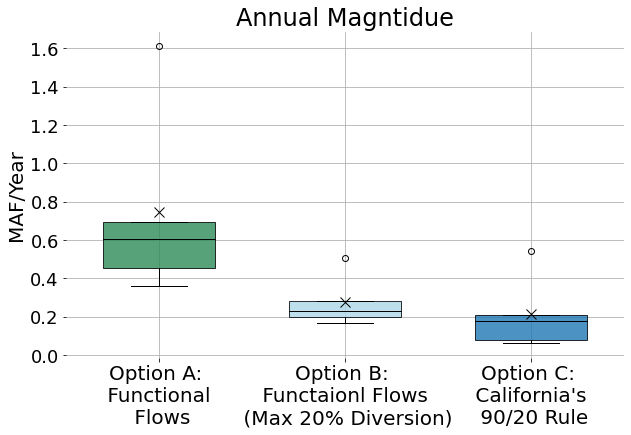

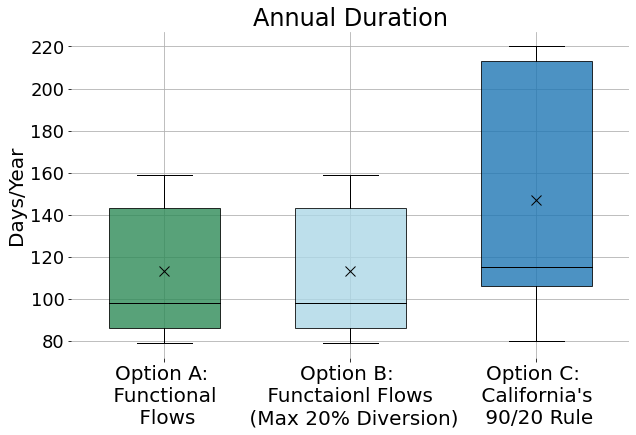

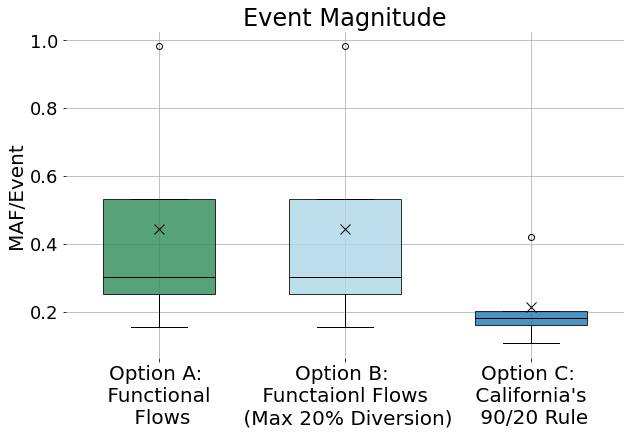

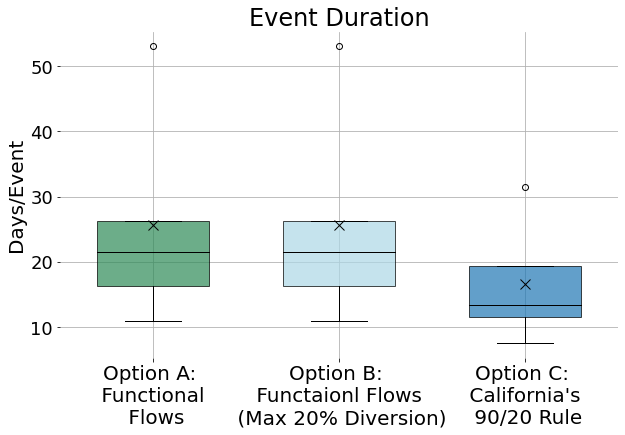

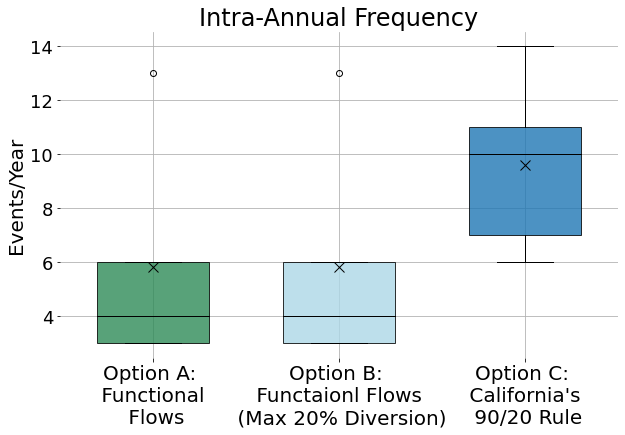

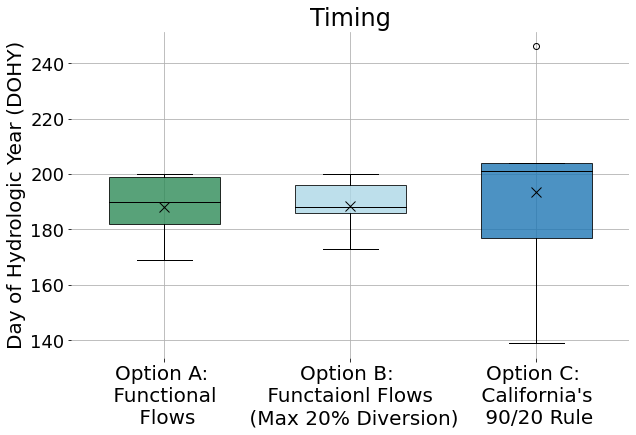

In [503]:
# Boxplot generation (data_daily_thres or data_rec_thres)
cols = option1_data.columns
titles = ['Annual Magntidue', 'Annual Duration', 'Event Magnitude', 'Event Duration', 'Intra-Annual Frequency', 'Timing']
ticks = ['Option A: \n Functional \n Flows', 'Option B: \n Functaionl Flows \n (Max 20% Diversion)', "Option C: \n California's \n 90/20 Rule"]
yaxes = ['MAF/Year', 'Days/Year', 'MAF/Event', 'Days/Event', 'Events/Year', 'Day of Hydrologic Year (DOHY)']
#color_list = ['C0', 'lightblue', 'seagreen', 'navy', 'yellow', 'coral']
color_list = ['seagreen', 'lightblue', 'C0']
alpha_list = [0.8, 0.8, 0.8, 0.7, 0.8, 0.8]

for j, col in enumerate(cols):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.boxplot(option1_data[option1_data[col] != 0][col], positions=[0], widths=0.6, patch_artist=True,
            boxprops=dict(facecolor=color_list[0], alpha=alpha_list[j]), 
            medianprops=dict(color='#000000'),
            showmeans=True, meanprops={"marker":"x", "markeredgecolor":"black", "markersize":"10"})
    ax.boxplot(option2_data[option2_data[col] != 0][col], positions=[1], widths=0.6, patch_artist=True,
            boxprops=dict(facecolor=color_list[1], alpha=alpha_list[j]), 
            medianprops=dict(color='#000000'),
            showmeans=True, meanprops={"marker":"x", "markeredgecolor":"black", "markersize":"10"})
    ax.boxplot(option3_data[option3_data[col] != 0][col], positions=[2], widths=0.6, patch_artist=True,
            boxprops=dict(facecolor=color_list[2], alpha=alpha_list[j]), 
            medianprops=dict(color='#000000'),
            showmeans=True, meanprops={"marker":"x", "markeredgecolor":"black", "markersize":"10"})
    ax.set_ylabel(yaxes[j], fontsize=20)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_xticklabels(ticks, fontsize=20)
    ax.set_title(titles[j], fontsize=24)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    file_name = f'../results/figures/box_plots/tuol_ff_compare_{col}.png'
    plt.savefig(file_name, bbox_inches="tight")
    
#ax.set_xticklabels('label', fontsize=24)

# customize plot
#plt.xticks('label', fontsize=24)
#ax.set_xticks([-1,0], ticks)
#ax.set_ylabel(yaxes, fontsize=24)
#plt.xlim(-2, len(ticks)*3)
#plt.ylim(0, 1)
#plt.title(f'HMF Metrics', fontsize=26)
#plt.tight_layout()

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

plt.show()

### Flow duration frequency plots

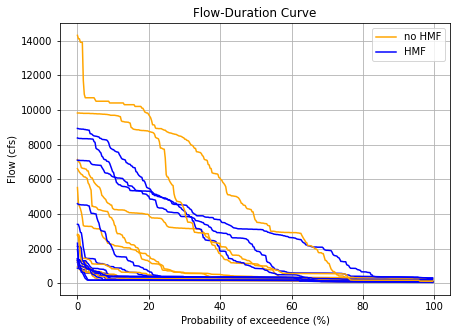

In [26]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    
def calc_hmf_years(df):
    return df.loc[df['hmf_cfs'] != 0].WY.unique() # list of years with HMFs

def plot_flow_dur_curve(df):
    start_year_range = int(df['year'][1])
    end_year_range = int(df['year'][-1])
    fig, ax1 = plt.subplots(1,1, figsize=(7,5))

    for year in np.arange(start_year_range, end_year_range):
        hmf_years = calc_hmf_years(df)
        if str(year) in hmf_years:
            daily_year = df[str(year)+'-10-01':str(year+1)+'-09-30'].sort_values(by=['flow_cfs'], ascending=False)
            prob_exc = [i/(len(daily_year)+1)*100 for i in range(len(daily_year))]
            ax1.plot(prob_exc, daily_year['flow_cfs'], color='blue', label='HMF')
        else:
            #pass
            daily_year = df[str(year)+'-10-01':str(year+1)+'-09-30'].sort_values(by=['flow_cfs'], ascending=False)
            prob_exc = [i/(len(daily_year)+1)*100 for i in range(len(daily_year))]
            ax1.plot(prob_exc, daily_year['flow_cfs'], color='orange', label='no HMF')

    legend_without_duplicate_labels(ax1)
    ax1.set_xlabel('Probability of exceedence (%)')
    ax1.set_ylabel('Flow (cfs)')
    ax1.set_title('Flow-Duration Curve')
    #plt.savefig('results/figures/flow_duration/Tuol/'+selected_record+'_'+selected_sites+'_'+'.png', bbox_inches="tight")
    #plt.savefig('11467000_RussianR_FlowDurationCurve.png')
    plt.show()
    
    return

plot_flow_dur_curve(df_daily_threshold)